In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [4]:
pairs = pd.read_csv("data/final/pairs.csv")

In [3]:
# Compute mean difference in pscores within each pair
pscore_diffs = (
    pairs.groupby("match_id")["pscore"]
    .apply(lambda x: x.max() - x.min())
    .reset_index(name="pscore_diff")
)

mean_diff = pscore_diffs["pscore_diff"].mean()

print("Overall mean difference:", mean_diff)


Overall mean difference: 0.021188020282428888


In [4]:
pairs = pairs[pairs['match_grade'] != 8].copy() 

In [5]:
CONTINUOUS_VARS = [
    'MA03',  # Grade 3 Math scores (pre-treatment for all)
    'RD03',  # Grade 3 Reading scores (pre-treatment for all)
]

# One-hot encoded demographic variables
CATEGORICAL_VARS = [
    'eds_Y',
    'sex_M',
    'ethnic_A',
    'ethnic_B',
    'ethnic_H',
    'ethnic_I',
    'ethnic_M',
    'ethnic_P',
    'ethnic_W',
]


ALL_COVARIATES = CONTINUOUS_VARS + CATEGORICAL_VARS

#Separate into treated and control groups
treated = pairs[pairs['treatment'] == 1]
control = pairs[pairs['treatment'] == 0]

balance_data = []
for var in ALL_COVARIATES:
    mean_treated = treated[var].mean()
    mean_control = control[var].mean()

    
    pooled_std = np.sqrt((treated[var].std(ddof=1)**2 + control[var].std(ddof=1)**2) / 2)

    if pooled_std > 0:
        smd = (mean_treated - mean_control) / pooled_std
    else:
        smd = 0.0

    balance_data.append({
        'Variable': var,
        'Treated Mean': mean_treated,
        'Control Mean': mean_control,
        'SMD': smd,
    })

balance_table = pd.DataFrame(balance_data)
balance_table = balance_table.set_index('Variable')

balance_table

,Treated Mean,Control Mean,SMD
Variable,,,
MA03,85.701171,85.735794,-0.003471
RD03,85.300600,85.514416,-0.019677
eds_Y,0.198609,0.178421,0.051630
sex_M,0.510836,0.516392,-0.011116
ethnic_A,0.034183,0.028542,0.032366
ethnic_B,0.084227,0.077103,0.026166
ethnic_H,0.087154,0.075618,0.042198
ethnic_I,0.008525,0.006955,0.017906
ethnic_M,0.034989,0.025362,0.056298


In [6]:
balance_table.to_excel('balance_table.xlsx', index=True)

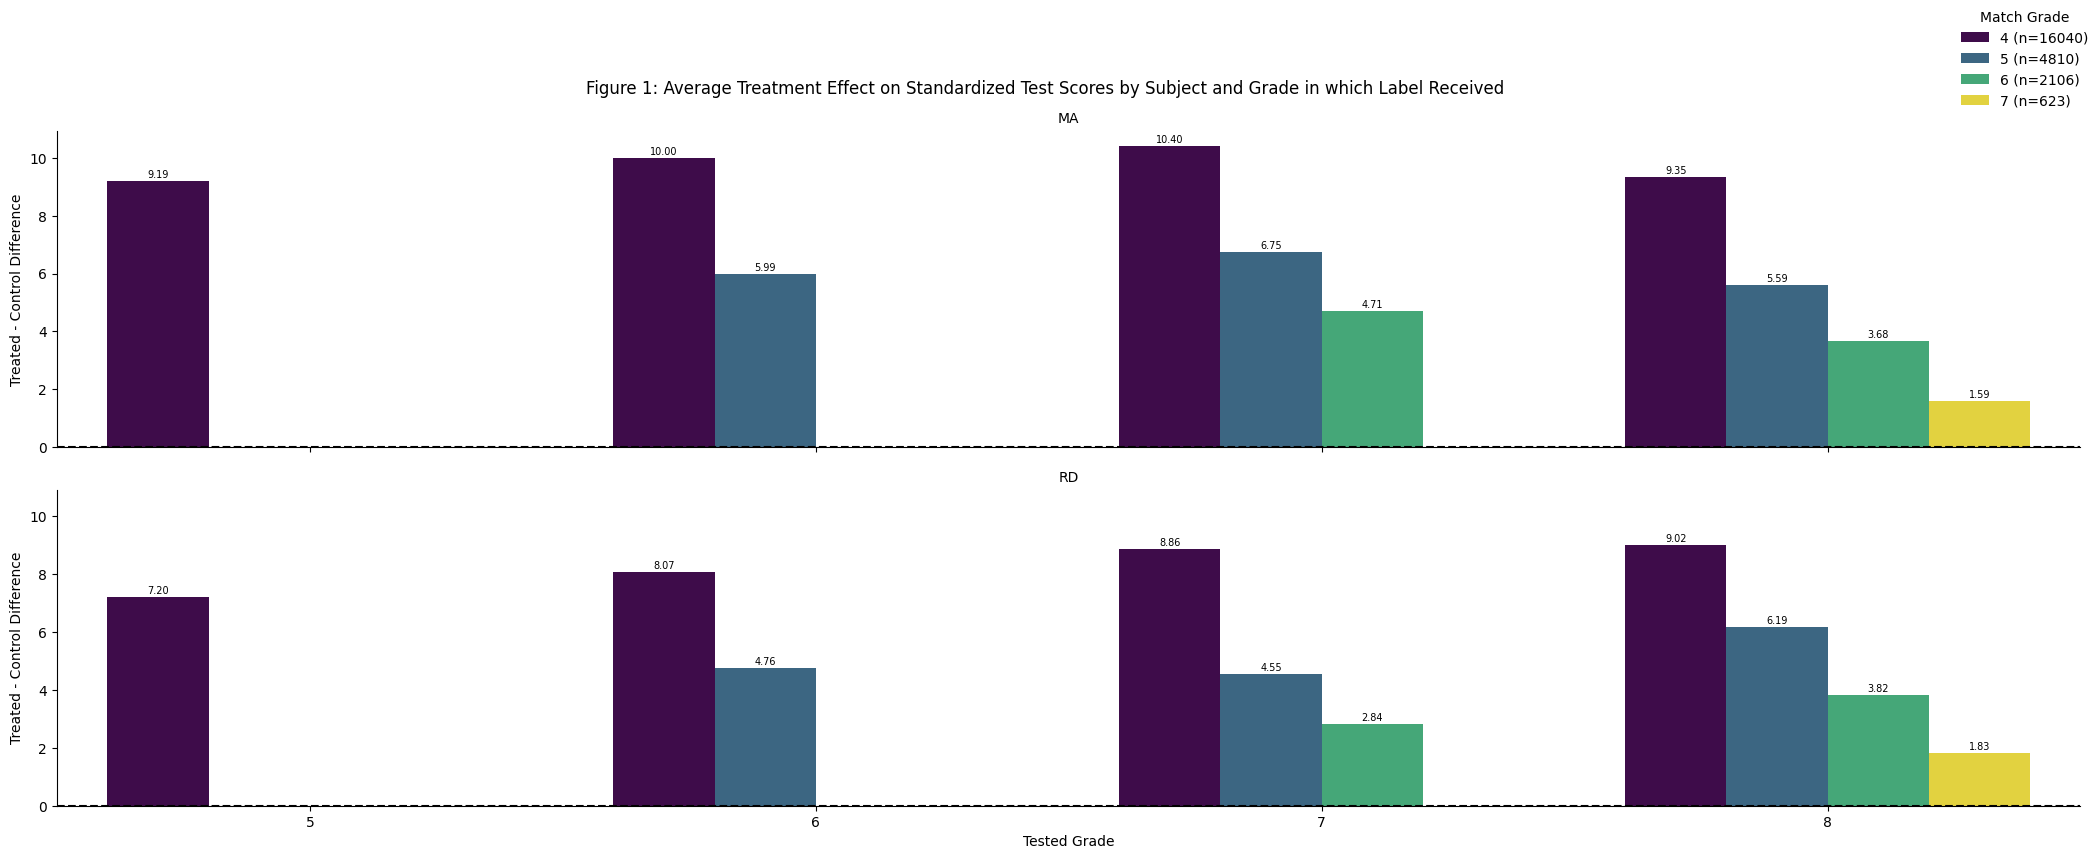

In [37]:
#ATEs by grade
from scipy.stats import ttest_ind

gifted_grades = list(range(4, 8))
post_effects_trimmed = []

# Loop through each match grade cohort
for grade in gifted_grades:
    df_g = pairs[pairs['match_grade'] == grade].copy()
    if df_g.empty:
        continue

    test_cols = [col for col in df_g.columns if col.startswith(('MA', 'RD'))]
    post_cols = [col for col in test_cols if int(col.split('0')[1]) > grade]

    for col in sorted(post_cols, key=lambda x: int(x.split('0')[1])):
        means = df_g.groupby('treatment')[col].mean()
        n = df_g.groupby('treatment')[col].count()

        tstat, pval = ttest_ind(
            df_g[df_g['treatment'] == 1][col],
            df_g[df_g['treatment'] == 0][col],
            nan_policy='omit'
        )

        post_effects_trimmed.append({
            'match_grade': grade,
            'score_col': col,
            'treated_mean': means.get(1, float('nan')),
            'control_mean': means.get(0, float('nan')),
            'difference': means.get(1, float('nan')) - means.get(0, float('nan')),
            'treated_n': n.get(1, 0),
            'control_n': n.get(0, 0),
            'p_value': pval
        })

effects_trimmed_df = pd.DataFrame(post_effects_trimmed)
effects_trimmed_df = effects_trimmed_df.sort_values(by=['match_grade', 'score_col'])

effects_trimmed_df['subject'] = effects_trimmed_df['score_col'].apply(lambda x: x.split('0')[0])
effects_trimmed_df['score_grade'] = effects_trimmed_df['score_col'].apply(lambda x: int(x.split('0')[1]))

viz_df = effects_trimmed_df.copy()

g = sns.FacetGrid(
    viz_df,
    row="subject",
    sharey=True,
    height=4,
    aspect=5
)

# Draw grouped bars in each facet
g.map_dataframe(
    sns.barplot,
    x='score_grade',
    y='difference',
    hue='match_grade',
    palette='viridis',
    dodge=True
)

# Add horizontal line and annotations
for ax in g.axes.flat:
    ax.axhline(0, color='black', linestyle='--')
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + (0.05 if height >= 0 else -0.15),
                f'{height:.2f}',
                ha='center',
                va='bottom' if height >= 0 else 'top',
                fontsize=7
            )


# Clean up plot
g.set_titles("{row_name}")
g.set_axis_labels("Tested Grade", "Treated - Control Difference")


# Compute total n for each match_grade
n_by_grade = viz_df.groupby("match_grade")["treated_n"].max().to_dict()
# ^ use max() because within a match_grade all rows should have the same n

# After g.add_legend()
g.add_legend(title="Match Grade")

# Update legend labels to include n
new_labels = [f"{lab.get_text()} (n={n_by_grade[int(lab.get_text())]})"
              for lab in g._legend.texts]

for text_obj, new_text in zip(g._legend.texts, new_labels):
    text_obj.set_text(new_text)

# Move legend if you want
g._legend.set_bbox_to_anchor((1, 1))

g.fig.suptitle("Figure 1: Average Treatment Effect on Standardized Test Scores by Subject and Grade in which Label Received")


plt.tight_layout()
plt.show()



In [8]:
did_results = []

for subject in ['MA', 'RD']:
    pre = f'{subject}03'
    post = f'{subject}08'

    df = pairs.copy()
    df['change'] = df[post] - df[pre]

    treated = df[df['treatment'] == 1]['change']
    control = df[df['treatment'] == 0]['change']

    diff_treated = treated.mean()
    diff_control = control.mean()
    did = diff_treated - diff_control

    # --- New code for p-value ---
    # Perform an independent t-test to get the t-statistic and p-value.
    # We set equal_var=True to align with your pooled standard deviation calculation.
    t_stat, p_value = stats.ttest_ind(treated, control, equal_var=True)
    # ----------------------------

    # Sample sizes
    n_treated = treated.count()
    n_control = control.count()

    # Standard deviations
    std_treated = treated.std(ddof=1)
    std_control = control.std(ddof=1)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n_treated - 1)*std_treated**2 + (n_control - 1)*std_control**2) / (n_treated + n_control - 2))

    # Cohen's d
    cohen_d = did / pooled_std

    # Standard error of the difference in means
    se_diff = np.sqrt((std_treated**2 / n_treated) + (std_control**2 / n_control))

    # 95% confidence interval
    t_crit = stats.t.ppf(0.975, df=n_treated + n_control - 2)
    ci_low = did - t_crit * se_diff
    ci_high = did + t_crit * se_diff

    did_results.append({
        'subject': subject,
        'treated_mean_change': diff_treated,
        'control_mean_change': diff_control,
        'difference_in_difference': did,
        't_statistic': t_stat, # Also added the t-statistic
        'treated_n': n_treated,
        "Cohen's D": cohen_d,
        "CI Lower": ci_low,
        "CI upper": ci_high
    })

did_df = pd.DataFrame(did_results)
did_df

,subject,treated_mean_change,control_mean_change,difference_in_difference,t_statistic,treated_n,Cohen's D,CI Lower,CI upper
0,MA,-3.286599,-11.195553,7.908954,48.492530,23579,0.446609,7.589283,8.228625
1,RD,-6.396882,-14.398853,8.001971,49.061826,23579,0.451852,7.682293,8.321649


In [9]:
did_df.to_excel("did.xlsx", index=False)

In [10]:
baseline_means = pairs.groupby('treatment')[['MA03', 'RD03']].mean().round(2)
baseline_means.index = baseline_means.index.map({0: 'Control', 1: 'Treated'})
baseline_means

,MA03,RD03
treatment,,
Control,85.74,85.51
Treated,85.70,85.30


In [11]:
baseline_end = pairs.groupby('treatment')[['MA08', 'RD08']].mean().round(2)
baseline_end.index = baseline_end.index.map({0: 'Control', 1: 'Treated'})
baseline_end

,MA08,RD08
treatment,,
Control,74.54,71.12
Treated,82.41,78.90


In [12]:
baseline_means_melted = baseline_means.reset_index().melt(
    id_vars='treatment', 
    var_name='subject', 
    value_name='baseline_pre'
)
baseline_means_melted['subject'] = baseline_means_melted['subject'].str.replace('MA03', 'math').str.replace('RD03', 'reading')

baseline_end_melted = baseline_end.reset_index().melt(
    id_vars='treatment', 
    var_name='subject', 
    value_name='baseline_post'
)
baseline_end_melted['subject'] = baseline_end_melted['subject'].str.replace('MA08', 'math').str.replace('RD08', 'reading')

# Merge pre- and post-treatment data
plot_df = pd.merge(
    baseline_means_melted, 
    baseline_end_melted, 
    on=['treatment', 'subject']
)

# Merge with did_df to get Cohen's D and CI for annotation
did_df_renamed = did_df.copy()
did_df_renamed['subject'] = did_df_renamed['subject'].str.replace('MA', 'math').str.replace('RD', 'reading')
plot_df = pd.merge(plot_df, did_df_renamed, on='subject')

# # Plotting
# grades = ['Grade 3', 'Grade 8']
# colors = {'Treated': 'tab:blue', 'Control': 'tab:orange'}
# linestyles = {'math': '-', 'reading': '--'}

# fig, ax = plt.subplots(figsize=(5, 7))

# for _, row in plot_df.iterrows():
#     subject = row['subject']
#     treatment_group = row['treatment']
    
#     # Check if this row corresponds to the control group
#     if treatment_group == 'Control':
#         y_values = [row['baseline_pre'], row['baseline_post']]
#         ax.plot(
#             grades, 
#             y_values, 
#             color=colors[treatment_group], 
#             linestyle=linestyles[subject], 
#             marker='o',
#             label=f'Control {subject.capitalize()}'
#         )
#     # Check if this row corresponds to the treated group
#     elif treatment_group == 'Treated':
#         y_values = [row['baseline_pre'], row['baseline_post']]
#         ax.plot(
#             grades, 
#             y_values, 
#             color=colors[treatment_group], 
#             linestyle=linestyles[subject], 
#             marker='o',
#             label=f'Treated {subject.capitalize()}'
#         )
        
        # # Add CI for the treated group at Grade 8
        # ci_half = (row['CI upper'] - row['CI Lower']) / 2
        # ax.errorbar(
        #     grades[1], 
        #     row['baseline_post'], 
        #     yerr=ci_half, 
        #     fmt='none', 
        #     ecolor=colors[treatment_group], 
        #     capsize=4, 
        #     lw=1.5
        # )

# # Legends
# group_handles = [
#     Line2D([0], [0], color=colors['Treated'], lw=2, label='Treated'),
#     Line2D([0], [0], color=colors['Control'], lw=2, label='Control')
# ]
# subject_handles = [
#     Line2D([0], [0], color='black', linestyle='-', lw=2, label='Math'),
#     Line2D([0], [0], color='black', linestyle='--', lw=2, label='Reading')
# ]
# legend1 = ax.legend(handles=group_handles, title='Group', loc='upper right')
# legend2 = ax.legend(handles=subject_handles, title='Subject', loc='upper center')
# ax.add_artist(legend1)

# # Final touches
# ax.set_title('Difference in Difference -- Percentiles by Subject\nColor = Group, Line = Subject (95% CI at Grade 8)')
# ax.set_ylabel('Average Percentile')
# ax.set_xlabel('Grade')
# ax.grid(True)
# plt.tight_layout()
# plt.show()

In [13]:
plot_df.to_excel("plot_df.xlsx", index=False)

In [7]:
# Fix: Remove rows where gifted students are in 8th grade (no post scores)
# BUT keep non-gifted students (gifted_grade == 0)


# Compute match-level post-grade based on the gifted student's gifted_grade
match_post_grade = (
    pairs[pairs['treatment'] == 1]
    .groupby('match_id')['gifted_grade']
    .first()
    .add(1)
    .rename('post_grade')
)

# Merge the post_grade into all rows based on match_id
pairs = pairs.merge(match_post_grade, on='match_id', how='inner')

# Create the column names for post-grade math and reading
pairs['post_math_col'] = 'MA0' + pairs['post_grade'].astype(str)
pairs['post_reading_col'] = 'RD0' + pairs['post_grade'].astype(str)

# Safely extract post scores using the computed column names
def extract_score(row, colname):
    try:
        return row[colname]
    except KeyError:
        return pd.NA

pairs['math_post'] = pairs.apply(lambda row: extract_score(row, row['post_math_col']), axis=1)
pairs['reading_post'] = pairs.apply(lambda row: extract_score(row, row['post_reading_col']), axis=1)

# Define outcomes to evaluate
outcomes = ['math_post', 'reading_post', 'MA08', 'RD08']
ate_results = []

# Loop through outcomes to estimate ATE and CI
for outcome_var in outcomes:
    df = pairs[['match_id', 'treatment', outcome_var]].dropna()

    # Ensure only match_ids with both treated and control
    matched = df.groupby('match_id')['treatment'].nunique()
    valid_ids = matched[matched == 2].index
    df = df[df['match_id'].isin(valid_ids)]

    pair_scores = df.pivot(index='match_id', columns='treatment', values=outcome_var)
    if pair_scores.shape[1] == 2:
        pair_scores.columns = ['control', 'treated']
        pair_scores['diff'] = pair_scores['treated'] - pair_scores['control']

        # ATE and 95% CI
        ate = pair_scores['diff'].mean()
        stderr = pair_scores['diff'].std(ddof=1) / (len(pair_scores['diff']) ** 0.5)
        ci_low, ci_high = stats.t.interval(0.95, df=len(pair_scores['diff'])-1, loc=ate, scale=stderr)

        ate_results.append({
            'outcome': outcome_var,
            'ATE': ate,
            '95% CI Lower': ci_low,
            '95% CI Upper': ci_high,
        })

# Display ATE results
ate_df = pd.DataFrame(ate_results)
print("Average Treatment Effects with 95% Confidence Intervals:")
ate_df

Average Treatment Effects with 95% Confidence Intervals:


,outcome,ATE,95% CI Lower,95% CI Upper
0,math_post,7.938334,7.698790,8.177878
1,reading_post,6.169452,5.909038,6.429865
2,MA08,7.782984,7.502085,8.063883
3,RD08,7.672418,7.379474,7.965362


In [8]:
subgroup_vars = ['sex_M', 'sex_F', 'eds_Y', 'eds_N', 'ethnic_W', 'ethnic_B', 'ethnic_H', 'ethnic_A', 'ethnic_I', 'ethnic_M', 'ethnic_P']
outcome_vars = ['math_post', 'reading_post']
results = []

# --- 2. Create Inverse Boolean Columns ---
# This is a good practice to ensure all subgroups are explicitly defined.
pairs['eds_N'] = ~pairs['eds_Y']
pairs['sex_F'] = ~pairs['sex_M']

# --- 3. Iterate and Calculate Metrics ---
for subgroup in subgroup_vars:
    for outcome in outcome_vars:
        # Filter the dataframe for the current subgroup
        subgroup_df = pairs[pairs[subgroup] == True]
        if subgroup_df.empty:
            continue

        # Pivot to get treated and control scores side-by-side for each pair
        pair_scores = subgroup_df.pivot_table(index='match_id', columns='treatment', values=outcome)
        
        # Ensure both treatment and control columns exist
        if 0 not in pair_scores.columns or 1 not in pair_scores.columns:
            continue

        pair_scores.rename(columns={0: 'control', 1: 'treated'}, inplace=True)
        pair_scores.dropna(inplace=True) # Drop pairs with missing scores
        n_pairs = len(pair_scores)

        # Proceed only if there are enough pairs to calculate stats
        if n_pairs > 1:
            # Calculate the difference for each pair
            diff = pair_scores['treated'] - pair_scores['control']
            
            # --- CALCULATIONS ---
            ate = diff.mean()
            std_dev_diff = diff.std(ddof=1) # Standard deviation of the differences

            # Calculate Cohen's d for paired samples
            # Check for zero standard deviation to avoid division error
            if std_dev_diff > 0:
                cohens_d = ate / std_dev_diff
            else:
                cohens_d = 0.0 # If there's no variation in differences, effect size is 0

            # Calculate standard error and confidence interval
            stderr = std_dev_diff / (n_pairs ** 0.5)
            if stderr > 0:
                ci_low, ci_high = stats.t.interval(0.95, df=n_pairs - 1, loc=ate, scale=stderr)
            else:
                ci_low, ci_high = ate, ate

            # Append all results to the list
            results.append({
                'Subgroup': subgroup,
                'Outcome': outcome,
                'N Pairs': n_pairs,
                'ATE': ate,
                'Cohens_d': cohens_d, # Added Cohen's d here
                '95% CI Lower': ci_low,
                '95% CI Upper': ci_high
            })

# --- 4. Display Results ---
results_df = pd.DataFrame(results)
results_df


,Subgroup,Outcome,N Pairs,ATE,Cohens_d,95% CI Lower,95% CI Upper
0,sex_M,math_post,11175,8.205613,0.430875,7.852487,8.558740
1,sex_M,reading_post,11175,6.434791,0.303054,6.041073,6.828509
2,sex_F,math_post,10533,7.497144,0.407424,7.145688,7.848601
3,sex_F,reading_post,10533,5.889568,0.300919,5.515754,6.263383
4,eds_Y,math_post,3761,8.306480,0.400330,7.643142,8.969819
5,eds_Y,reading_post,3761,6.871870,0.304264,6.149832,7.593908
6,eds_N,math_post,18450,7.821468,0.429647,7.558771,8.084164
7,eds_N,reading_post,18450,6.137017,0.308551,5.849999,6.424035
8,ethnic_W,math_post,17600,7.806032,0.423860,7.533932,8.078133
9,ethnic_W,reading_post,17600,6.375956,0.320069,6.081633,6.670279


In [9]:
results_df.to_excel("post_subgroups.xlsx", index=False)

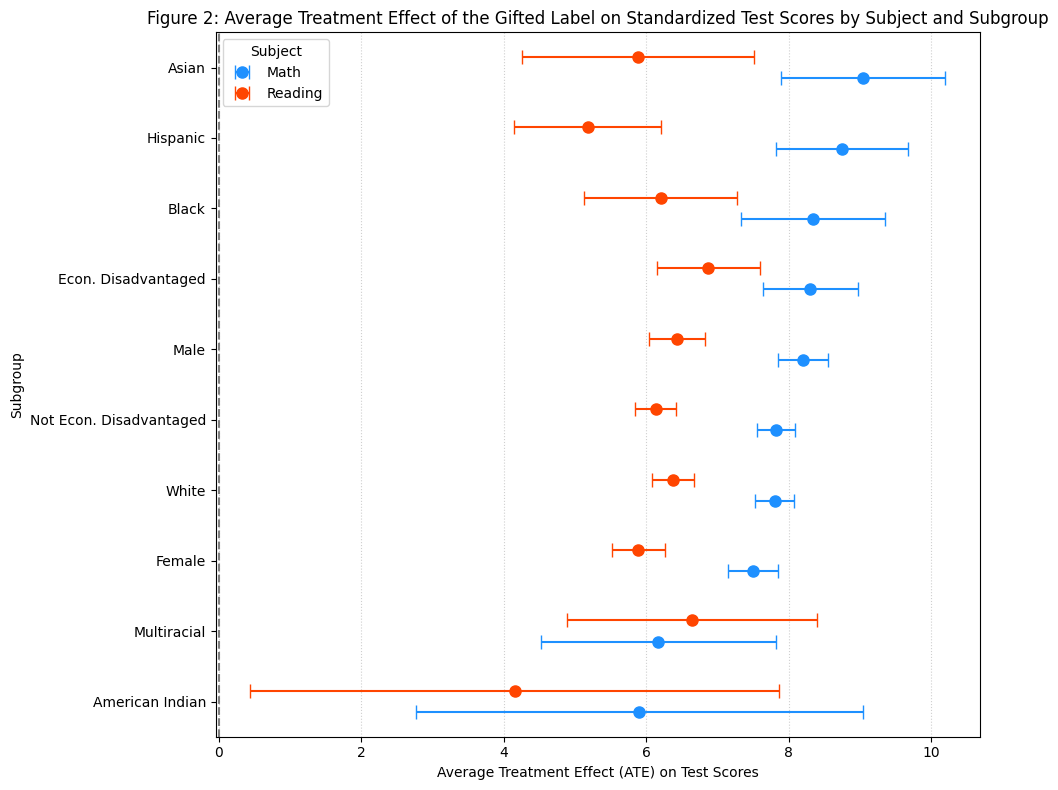

In [38]:
df_plot = results_df.copy()

# Define a mapping from the 'Subgroup' column codes to clean, readable labels.
label_mapping = {
    'sex_M': 'Male', 'sex_F': 'Female', 'eds_Y': 'Econ. Disadvantaged',
    'eds_N': 'Not Econ. Disadvantaged', 'ethnic_W': 'White', 'ethnic_B': 'Black',
    'ethnic_H': 'Hispanic', 'ethnic_A': 'Asian', 'ethnic_I': 'American Indian',
    'ethnic_M': 'Multiracial', 'ethnic_P': 'Pacific Islander'
}
df_plot['Group'] = df_plot['Subgroup'].map(label_mapping)
df_plot['Subject'] = df_plot['Outcome'].map({'math_post': 'Math', 'reading_post': 'Reading'})
df_plot.dropna(subset=['Group', 'Subject'], inplace=True)

# Calculate the error margin for the error bars
df_plot['error'] = df_plot['95% CI Upper'] - df_plot['ATE']

# --- 3. Sort and Position Data ---
# Create a sorted list of group names based on the Math ATE for a clean y-axis order
math_ates = df_plot[df_plot['Subject'] == 'Math'].set_index('Group')['ATE']
sorted_groups = math_ates.sort_values(ascending=True).index.tolist()

# Create a mapping from group name to y-axis position
y_pos_map = {group: i for i, group in enumerate(sorted_groups)}
df_plot['y_pos'] = df_plot['Group'].map(y_pos_map)

# Define an offset to separate the Math and Reading points for each group
y_offset = 0.15
df_plot['plot_y'] = df_plot['y_pos'] + df_plot['Subject'].map({'Math': -y_offset, 'Reading': y_offset})


# --- 4. Generate the Plot ---
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Math and Reading points with error bars separately
math_df = df_plot[df_plot['Subject'] == 'Math']
ax.errorbar(x=math_df['ATE'], y=math_df['plot_y'], xerr=math_df['error'],
            fmt='o', color='dodgerblue', capsize=5, label='Math', markersize=8)

reading_df = df_plot[df_plot['Subject'] == 'Reading']
ax.errorbar(x=reading_df['ATE'], y=reading_df['plot_y'], xerr=reading_df['error'],
            fmt='o', color='orangered', capsize=5, label='Reading', markersize=8)

# --- 5. Formatting ---
ax.axvline(0, color='gray', linestyle='--')
ax.set_yticks(ticks=range(len(sorted_groups)))
ax.set_yticklabels(sorted_groups)
ax.set_ylim(-0.5, len(sorted_groups) - 0.5)

ax.set_xlabel("Average Treatment Effect (ATE) on Test Scores")
ax.set_ylabel("Subgroup")
ax.legend(title='Subject', loc='best')
ax.grid(True, axis='x', linestyle=':', alpha=0.6)
ax.set_title("Figure 2: Average Treatment Effect of the Gifted Label on Standardized Test Scores by Subject and Subgroup")

plt.tight_layout()
plt.show()

In [22]:
#test statistic!! for differences

from scipy.stats import norm
df_plot['SE_ATE'] = df_plot['error'] / 1.96


comparison_pairs = [
    ('Male vs Female', 'sex_M', 'sex_F'),
    ('Econ. Disadvantaged vs Not', 'eds_Y', 'eds_N')
]

test_results = []

for subject in df_plot['Subject'].unique():
    subject_df = df_plot[df_plot['Subject'] == subject]

    for label, group1_code, group2_code in comparison_pairs:
        g1_data = subject_df[subject_df['Subgroup'] == group1_code].iloc[0]
        ate1 = g1_data['ATE']
        se1 = g1_data['SE_ATE']

        g2_data = subject_df[subject_df['Subgroup'] == group2_code].iloc[0]
        ate2 = g2_data['ATE']
        se2 = g2_data['SE_ATE']

        ate_diff = ate1 - ate2

      
        se_diff = np.sqrt(se1**2 + se2**2)

        z_stat = ate_diff / se_diff


        p_value = 2 * norm.sf(abs(z_stat)) # sf is survival function (1 - CDF)

        is_significant = 'Yes' if p_value < 0.05 else 'No'

        test_results.append({
            'Subject': subject,
            'Comparison': label,
            'ATE Difference (G1 - G2)': ate_diff,
            'SE Difference': se_diff,
            'Z-Statistic': z_stat,
            'P-Value': p_value,
            'Significant (p < 0.05)': is_significant
        })

results_df_test = pd.DataFrame(test_results)
results_df_test['ATE Difference (G1 - G2)'] = results_df_test['ATE Difference (G1 - G2)'].round(4)
results_df_test['SE Difference'] = results_df_test['SE Difference'].round(4)
results_df_test['Z-Statistic'] = results_df_test['Z-Statistic'].round(2)
results_df_test['P-Value'] = results_df_test['P-Value'].round(4)

print(results_df_test.to_string(index=False))

Subject                 Comparison  ATE Difference (G1 - G2)  SE Difference  Z-Statistic  P-Value Significant (p < 0.05)
   Math             Male vs Female                    0.7085         0.2542         2.79   0.0053                    Yes
   Math Econ. Disadvantaged vs Not                    0.4850         0.3640         1.33   0.1827                     No
Reading             Male vs Female                    0.5452         0.2770         1.97   0.0490                    Yes
Reading Econ. Disadvantaged vs Not                    0.7349         0.3964         1.85   0.0638                     No


In [25]:
from statsmodels.sandbox.stats.multicomp import multipletests

REFERENCE_CODE = 'ethnic_W'
comparison_codes = [
    'ethnic_B', 'ethnic_H', 'ethnic_A', 'ethnic_I', 'ethnic_M', 'ethnic_P'
]

raw_test_results = []

for subject in df_plot['Subject'].unique():
    subject_df = df_plot[df_plot['Subject'] == subject].copy() # Ensure we use a copy for filtering

    ref_data = subject_df[subject_df['Subgroup'] == REFERENCE_CODE]
    if ref_data.empty:
        print(f"Reference group {REFERENCE_CODE} not found for {subject}.")
        continue

    ate_ref = ref_data.iloc[0]['ATE']
    se_ref = ref_data.iloc[0]['SE_ATE']
    ref_label = ref_data.iloc[0]['Group']

    for comp_code in comparison_codes:
        comp_data = subject_df[subject_df['Subgroup'] == comp_code]
        if comp_data.empty:
            continue

        ate_comp = comp_data.iloc[0]['ATE']
        se_comp = comp_data.iloc[0]['SE_ATE']
        comp_label = comp_data.iloc[0]['Group']

    
        ate_diff = ate_ref - ate_comp

        se_diff = np.sqrt(se_ref**2 + se_comp**2)

        z_stat = ate_diff / se_diff

        p_value = 2 * norm.sf(abs(z_stat))

        raw_test_results.append({
            'Subject': subject,
            'Comparison': f'{ref_label} vs {comp_label}',
            'ATE Difference (Ref - Comp)': ate_diff,
            'Z-Statistic': z_stat,
            'P-Value (Uncorrected)': p_value
        })


raw_results_df = pd.DataFrame(raw_test_results)
uncorrected_pvalues = raw_results_df['P-Value (Uncorrected)'].tolist()

reject, pvals_corrected, _, _ = multipletests(
    uncorrected_pvalues, alpha=0.05, method='bonferroni'
)

raw_results_df['P-Value (Corrected)'] = pvals_corrected

raw_results_df['Significant (p < 0.05)'] = np.where(reject, 'Yes', 'No')


print("\n--- Pairwise ATE Comparison (Reference: White) with Bonferroni Correction ---")


format_dict = {
    'ATE Difference (Ref - Comp)': '{:.4f}',
    'Z-Statistic': '{:.2f}',
    'P-Value (Uncorrected)': '{:.4f}',
    'P-Value (Corrected)': '{:.4f}'
}
for col, f in format_dict.items():
    raw_results_df[col] = raw_results_df[col].map(f.format)

print(raw_results_df.to_string(index=False))


--- Pairwise ATE Comparison (Reference: White) with Bonferroni Correction ---
Subject               Comparison ATE Difference (Ref - Comp) Z-Statistic P-Value (Uncorrected) P-Value (Corrected) Significant (p < 0.05)
   Math           White vs Black                     -0.5368       -1.00                0.3150              1.0000                     No
   Math        White vs Hispanic                     -0.9423       -1.91                0.0556              0.5555                     No
   Math           White vs Asian                     -1.2424       -2.06                0.0394              0.3943                     No
   Math White vs American Indian                      1.9048        1.19                0.2359              1.0000                     No
   Math     White vs Multiracial                      1.6335        1.92                0.0547              0.5468                     No
Reading           White vs Black                      0.1735        0.31                0.760

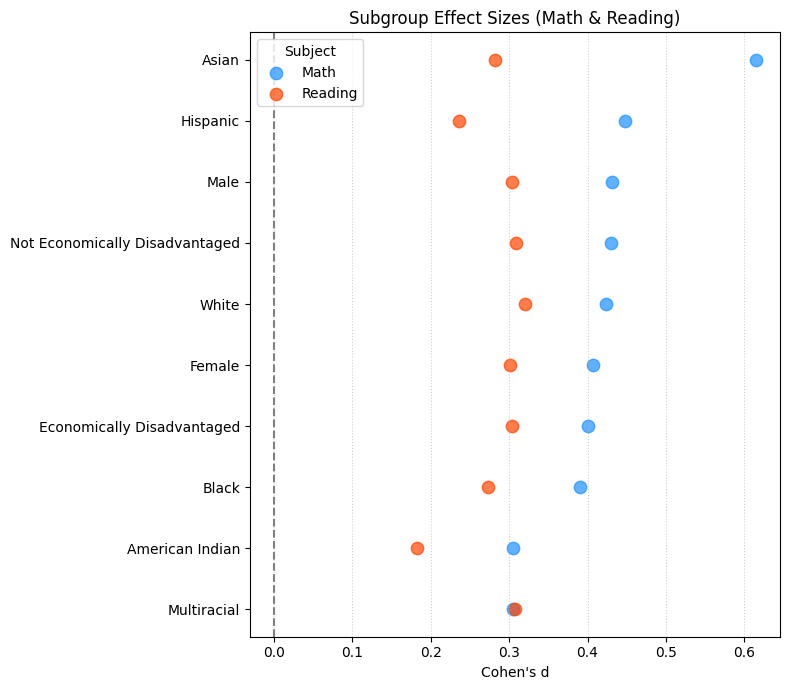

In [18]:

for subgroup in subgroup_vars:
    for outcome in outcome_vars:
        subgroup_df = pairs[pairs[subgroup] == True]
        if subgroup_df.empty:
            continue

        pair_scores = subgroup_df.pivot_table(index='match_id', columns='treatment', values=outcome)
        if 0 not in pair_scores.columns or 1 not in pair_scores.columns:
            continue

        pair_scores.rename(columns={0: 'control', 1: 'treated'}, inplace=True)
        pair_scores.dropna(inplace=True)
        n_pairs = len(pair_scores)

        if n_pairs > 1:
            diff = pair_scores['treated'] - pair_scores['control']
            
            # Calculate the standard deviation of the differences.
            std_diff = diff.std(ddof=1)
            
            # Calculate Cohen's d, handling cases where there is no variance.
            if std_diff > 0:
                d = diff.mean() / std_diff
            else:
                d = 0 # If there's no variation, the effect size is 0.

            results.append({
                'Subgroup': subgroup,
                'Outcome': outcome,
                "Cohen's d": d
            })

# Create the results DataFrame for plotting.
results_df_d = pd.DataFrame(results)


# --- 4. Plotting ---
# **UPDATED**: This section now plots Cohen's d from the new results DataFrame.
df_plot = results_df_d.copy()

label_mapping = {
    'sex_M': 'Male', 'sex_F': 'Female',
    'eds_Y': 'Economically Disadvantaged', 'eds_N': 'Not Economically Disadvantaged',
    'ethnic_W': 'White', 'ethnic_B': 'Black', 'ethnic_H': 'Hispanic',
    'ethnic_A': 'Asian', 'ethnic_I': 'American Indian', 'ethnic_M': 'Multiracial',
    'ethnic_P': 'Pacific Islander'
}
df_plot['Group'] = df_plot['Subgroup'].map(label_mapping)
df_plot['Subject'] = df_plot['Outcome'].map({'math_post': 'Math', 'reading_post': 'Reading'})

# Pivot the data to get Math and Reading Cohen's d values in separate columns.
pivot_df = df_plot.pivot_table(index='Group', columns='Subject', values="Cohen's d").reset_index()
pivot_df.dropna(inplace=True)
pivot_df = pivot_df.sort_values(by='Math', ascending=True)

# Generate the plot.
plt.figure(figsize=(8, 7))
y_pos = range(len(pivot_df))

plt.scatter(pivot_df['Math'], y_pos, color='dodgerblue', s=80, alpha=0.7, label='Math')
plt.scatter(pivot_df['Reading'], y_pos, color='orangered', s=80, alpha=0.7, label='Reading')

plt.axvline(0, color='gray', linestyle='--')
plt.yticks(ticks=y_pos, labels=pivot_df['Group'])

plt.xlabel("Cohen's d") # Updated x-axis label
plt.title("Subgroup Effect Sizes (Math & Reading)")
plt.legend(title='Subject', loc='upper left')
plt.grid(True, axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

####












starting high school














####

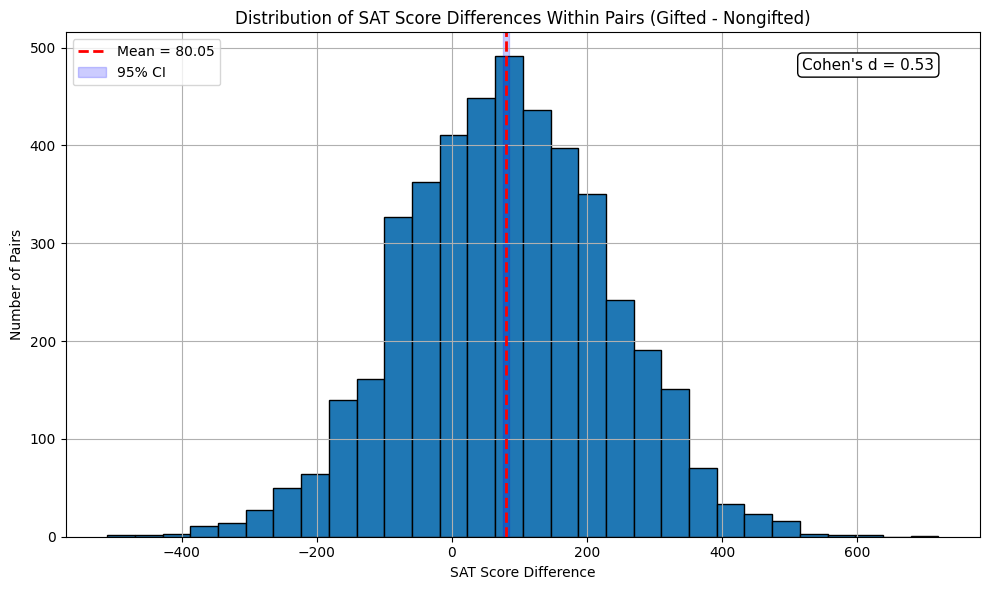

In [19]:
sat_scores = pd.read_csv("data/interim/sat.csv")
sats = pairs.merge(sat_scores, on='mastid',how='left')
sats.dropna(inplace=True)
duplicate_counts = sats['match_id'].value_counts()
duplicates_only = duplicate_counts[duplicate_counts > 1]

sats = sats[sats['match_id'].isin(duplicates_only.index)]

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Step 1: Sort so gifted comes first
sat_pairs = sats.sort_values('gifted_grade', ascending=False)

# Step 2: Compute SAT score difference: gifted − non-gifted
diffs = sat_pairs.groupby('match_id')['SAT_Total_Score_HC'].apply(
    lambda x: x.iloc[0] - x.iloc[1]
).reset_index(name='score_diff')

# Step 3: Drop any NaNs
sat_diff = diffs['score_diff'].dropna()

# Step 4: Compute stats
mean_diff = sat_diff.mean()
se_diff = stats.sem(sat_diff)
ci_lower, ci_upper = stats.t.interval(
    0.95, df=len(sat_diff) - 1, loc=mean_diff, scale=se_diff
)
cohen_d = mean_diff / sat_diff.std(ddof=1)

# Step 5: Plot
plt.figure(figsize=(10, 6))
plt.hist(sat_diff, bins=30, edgecolor='black')
plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_diff:.2f}')
plt.axvspan(ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')

# Add Cohen's d text
plt.text(0.95, 0.95, f"Cohen's d = {cohen_d:.2f}", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=11,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Final touches
plt.title('Distribution of SAT Score Differences Within Pairs (Gifted - Nongifted)')
plt.xlabel('SAT Score Difference')
plt.ylabel('Number of Pairs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
gpa = pd.read_csv("data/interim/gpa_master.csv")
gpa = gpa[['mastid','gpa_unweighted','gpa_weighted','bound_for']]

gpa_matches = pairs.merge(gpa, on='mastid', how='left')

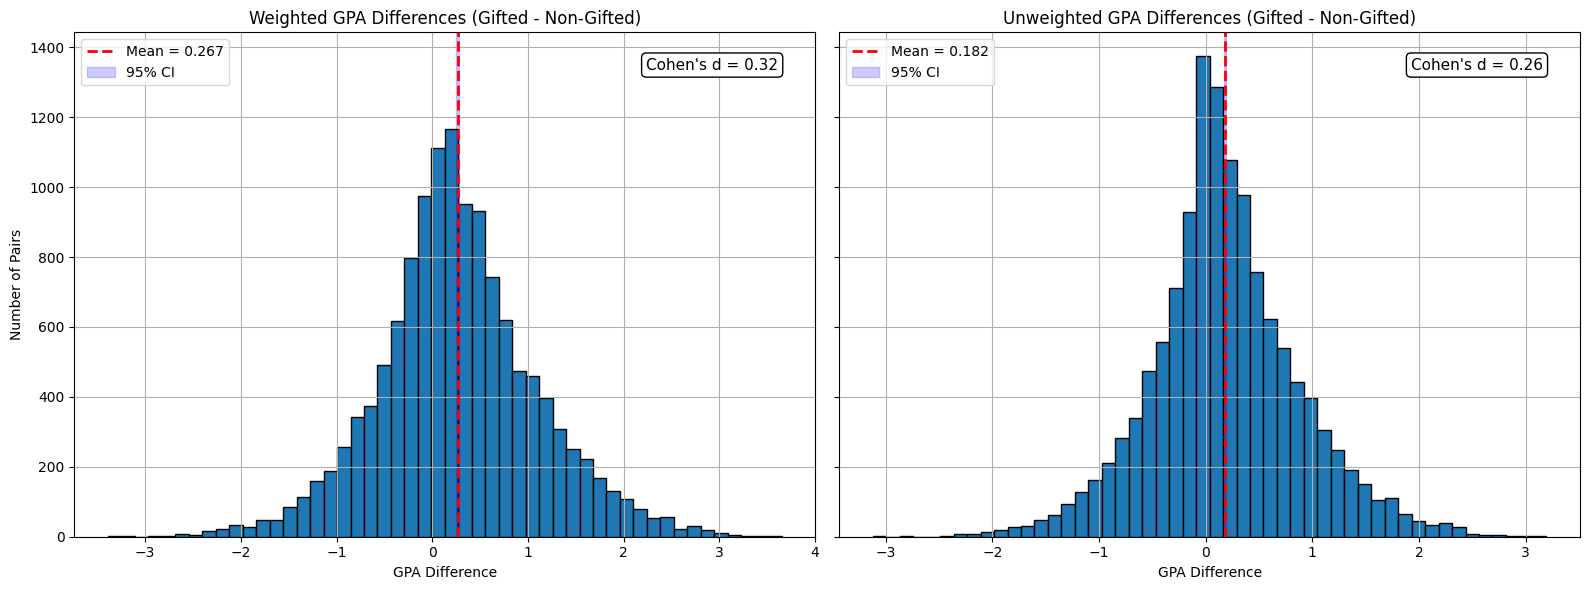

In [12]:


# # Step 1: Recode bound_for labels
# def recode_bound_for(val):
#     if pd.isna(val):
#         return val
#     val_lower = val.lower()
#     if "institution" in val_lower:
#         return "college"
#     elif "tech" in val_lower:
#         return "community college"
#     elif "employment" in val_lower:
#         return "employment"
#     else:
#         return None  # Filter out all other categories

# gpa_matches['bound_for'] = gpa_matches['bound_for'].apply(recode_bound_for)

# # Step 2: Pivot into matched pairs (using the new variable name)
# bound_for_pairs = gpa_matches.pivot(index='match_id', columns='treatment', values='bound_for').dropna()
# bound_for_pairs.columns = ['non_gifted_bound_for', 'gifted_bound_for']

# # Step 3: Filter to only the three target categories
# valid_categories = ['college', 'community college', 'employment']
# bound_for_pairs = bound_for_pairs[
#     bound_for_pairs['non_gifted_bound_for'].isin(valid_categories) &
#     bound_for_pairs['gifted_bound_for'].isin(valid_categories)
# ]

# # Step 4: Count unique pairings
# pair_counts = bound_for_pairs.value_counts().reset_index(name='count')

# # Step 5: Create pivot table
# pivot_table = pair_counts.pivot(
#     index='non_gifted_bound_for',
#     columns='gifted_bound_for',
#     values='count'
# ).fillna(0)

# # Step 6: Filter to rows with any value > 10
# # (Changed from 100 in your original code to 10 to match your filter logic .gt(10))
# pivot_table = pivot_table[pivot_table.gt(10).any(axis=1)]

# # Step 7: Plot heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="Blues")
# plt.title("Match-Based Post-HS Plans")
# plt.xlabel("Gifted Student")
# plt.ylabel("Non-Gifted Student")
# plt.tight_layout()
# plt.show()
# Identify match_ids where any row has a NaN
bad_match_ids = gpa_matches[gpa_matches.isna().any(axis=1)]['match_id'].unique()

# Drop all rows with those match_ids
gpa_matches = gpa_matches[~gpa_matches['match_id'].isin(bad_match_ids)]

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Step 1: Sort to ensure gifted comes first
gpa_matches = gpa_matches.sort_values('gifted_grade', ascending=False)
gpa_matches['rank'] = gpa_matches.groupby('match_id').cumcount()

# Step 2: Separate gifted and non-gifted
gifted = gpa_matches[gpa_matches['rank'] == 0]
non_gifted = gpa_matches[gpa_matches['rank'] == 1]

# Step 3a: Weighted GPA difference
merged_weighted = gifted[['match_id', 'gpa_weighted']].merge(
    non_gifted[['match_id', 'gpa_weighted']],
    on='match_id',
    suffixes=('_gifted', '_nongifted')
)
merged_weighted['gpa_diff'] = merged_weighted['gpa_weighted_gifted'] - merged_weighted['gpa_weighted_nongifted']
weighted_diff = merged_weighted['gpa_diff'].dropna()
mean_weighted = weighted_diff.mean()
se_weighted = stats.sem(weighted_diff)
ci_weighted = stats.t.interval(0.95, df=len(weighted_diff) - 1, loc=mean_weighted, scale=se_weighted)
cohen_d_weighted = mean_weighted / weighted_diff.std(ddof=1)

#Step 3b: Unweighted GPA difference
merged_unweighted = gifted[['match_id', 'gpa_unweighted']].merge(
    non_gifted[['match_id', 'gpa_unweighted']],
    on='match_id',
    suffixes=('_gifted', '_nongifted')
)
merged_unweighted['gpa_diff'] = merged_unweighted['gpa_unweighted_gifted'] - merged_unweighted['gpa_unweighted_nongifted']
unweighted_diff = merged_unweighted['gpa_diff'].dropna()
mean_unweighted = unweighted_diff.mean()
se_unweighted = stats.sem(unweighted_diff)
ci_unweighted = stats.t.interval(0.95, df=len(unweighted_diff) - 1, loc=mean_unweighted, scale=se_unweighted)
cohen_d_unweighted = mean_unweighted / unweighted_diff.std(ddof=1)

# Step 4: Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Weighted GPA plot
axes[0].hist(weighted_diff, bins=50, edgecolor='black')
axes[0].axvline(mean_weighted, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_weighted:.3f}')
axes[0].axvspan(ci_weighted[0], ci_weighted[1], color='blue', alpha=0.2, label='95% CI')
axes[0].set_title('Weighted GPA Differences (Gifted - Non-Gifted)')
axes[0].set_xlabel('GPA Difference')
axes[0].set_ylabel('Number of Pairs')
axes[0].grid(True)
axes[0].legend()
axes[0].text(0.95, 0.95, f"Cohen's d = {cohen_d_weighted:.2f}",
             transform=axes[0].transAxes, ha='right', va='top', fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Unweighted GPA plot
axes[1].hist(unweighted_diff, bins=50, edgecolor='black')
axes[1].axvline(mean_unweighted, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_unweighted:.3f}')
axes[1].axvspan(ci_unweighted[0], ci_unweighted[1], color='blue', alpha=0.2, label='95% CI')
axes[1].set_title('Unweighted GPA Differences (Gifted - Non-Gifted)')
axes[1].set_xlabel('GPA Difference')
axes[1].grid(True)
axes[1].legend()
axes[1].text(0.95, 0.95, f"Cohen's d = {cohen_d_unweighted:.2f}",
             transform=axes[1].transAxes, ha='right', va='top', fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

In [22]:
#gemini code here

Analyzing 'gpa_weighted' with 12938 complete pairs.
Analyzing 'gpa_unweighted' with 12938 complete pairs.

--- GPA Analysis Results ---
     GPA Type  ATE (Mean Diff)  CI Lower  CI Upper        p-value  Cohen's d
0    Weighted         0.266910  0.252607  0.281213  4.120329e-235   0.321585
1  Unweighted         0.181814  0.169821  0.193806  5.834277e-161   0.261258


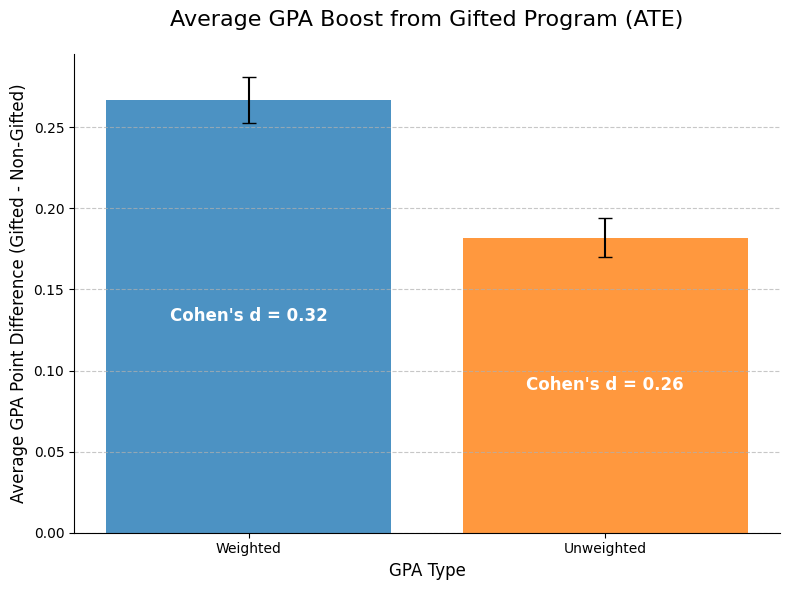

In [13]:

gpa_results = []
# Loop through each GPA type to analyze them independently
for gpa_type in ['gpa_weighted', 'gpa_unweighted']:
    
    # --- Robust Data Cleaning for each GPA type ---
    # Keep only the columns needed for this specific analysis
    gpa_subset = gpa_matches[['match_id', 'treatment', gpa_type]].copy()
    
    # Drop pairs where EITHER student is missing this specific GPA
    ids_with_nan = gpa_subset[gpa_subset[gpa_type].isna()]['match_id'].unique()
    gpa_clean = gpa_subset[~gpa_subset['match_id'].isin(ids_with_nan)]

    # Diagnostic print: Check how many pairs we are working with
    num_pairs = gpa_clean['match_id'].nunique()
    print(f"Analyzing '{gpa_type}' with {num_pairs} complete pairs.")
    
    # If no data is left, skip to the next GPA type
    if num_pairs == 0:
        continue

    # Separate gifted and non-gifted students
    gifted = gpa_clean[gpa_clean['treatment'] == 1].set_index('match_id')
    non_gifted = gpa_clean[gpa_clean['treatment'] == 0].set_index('match_id')

    # Align pairs by match_id
    gifted_scores = gifted[gpa_type]
    nongifted_scores = non_gifted[gpa_type]

    # Perform a paired t-test
    t_stat, p_value = stats.ttest_rel(gifted_scores, nongifted_scores)
    
    # Calculate the mean difference (ATE) and confidence interval
    diff = gifted_scores - nongifted_scores
    mean_diff = diff.mean()
    se_diff = stats.sem(diff)
    ci = stats.t.interval(0.95, df=len(diff) - 1, loc=mean_diff, scale=se_diff)

    # Calculate Cohen's d for paired samples
    cohen_d = mean_diff / diff.std(ddof=1)

    gpa_results.append({
        # FIX: Changed condition to be specific to 'gpa_weighted'
        'GPA Type': 'Weighted' if gpa_type == 'gpa_weighted' else 'Unweighted',
        'ATE (Mean Diff)': mean_diff,
        'CI Lower': ci[0],
        'CI Upper': ci[1],
        'p-value': p_value,
        "Cohens_d": cohen_d
    })
# Proceed with plotting only if there are results to plot
if gpa_results:
    gpa_results_df = pd.DataFrame(gpa_results)
    gpa_results_df_display = gpa_results_df.rename(columns={'Cohens_d': "Cohen's d"})
    print("\n--- GPA Analysis Results ---")
    print(gpa_results_df_display)

    # --- GPA Visualization ---
    fig, ax = plt.subplots(figsize=(8, 6))
    gpa_results_df['error'] = gpa_results_df['CI Upper'] - gpa_results_df['ATE (Mean Diff)']

    ax.bar(gpa_results_df['GPA Type'], gpa_results_df['ATE (Mean Diff)'],
           yerr=gpa_results_df['error'],
           capsize=5, color=['#1f77b4', '#ff7f0e'], alpha=0.8)

    ax.set_title('Average GPA Boost from Gifted Program (ATE)', fontsize=16, pad=20)
    ax.set_ylabel('Average GPA Point Difference (Gifted - Non-Gifted)', fontsize=12)
    ax.set_xlabel('GPA Type', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for index, row in gpa_results_df.iterrows():
        ax.text(index, row['ATE (Mean Diff)'] / 2, f"Cohen's d = {row['Cohens_d']:.2f}",
                ha='center', va='center', color='white', fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

In [24]:
gpa_results_df_display.to_excel('gpa_results.xlsx',index=False)


In [15]:

# --- 3. `bound_for` Analysis and Visualization ---

# Recode bound_for into cleaner categories
def recode_bound_for(val):
    if pd.isna(val):
        return 'Other/Unknown'
    val_lower = str(val).lower()
    if "senior" in val_lower:
        return "4-Year College"
    elif "community" in val_lower or "tech" in val_lower:
        return "2-Year College"
    elif "employment" in val_lower:
        return "Employment"
    elif "other" in val_lower:
        return "Other/Unknown"
    else:
        return 'Other/Unknown'

gpa_matches['pathway'] = gpa_matches['bound_for'].apply(recode_bound_for)

# Calculate proportions for each group, filling missing categories with 0
pathway_props = gpa_matches.groupby('treatment')['pathway'].value_counts(normalize=True).unstack().fillna(0)
pathway_props = pathway_props.rename(index={0: 'Non-Gifted', 1: 'Gifted'})

# Define a logical order for the plot and ensure all categories are present
category_order = [
    '4-Year College',
    '2-Year College',
    'Employment',
    'Other/Unknown'
]
# Add any missing categories from the data to the props dataframe with values of 0
for cat in category_order:
    if cat not in pathway_props.columns:
        pathway_props[cat] = 0
pathway_props = pathway_props[category_order] # Enforce the desired order


# --- Chi-Square Test ---
contingency_table = pd.crosstab(gpa_matches['treatment'], gpa_matches['pathway'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"\n--- Chi-Square Test for Post-Secondary Pathways ---")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"p-value: {p:.3e}")


--- Chi-Square Test for Post-Secondary Pathways ---
Chi-Square Statistic: 397.54
Degrees of Freedom: 3
p-value: 7.549e-86


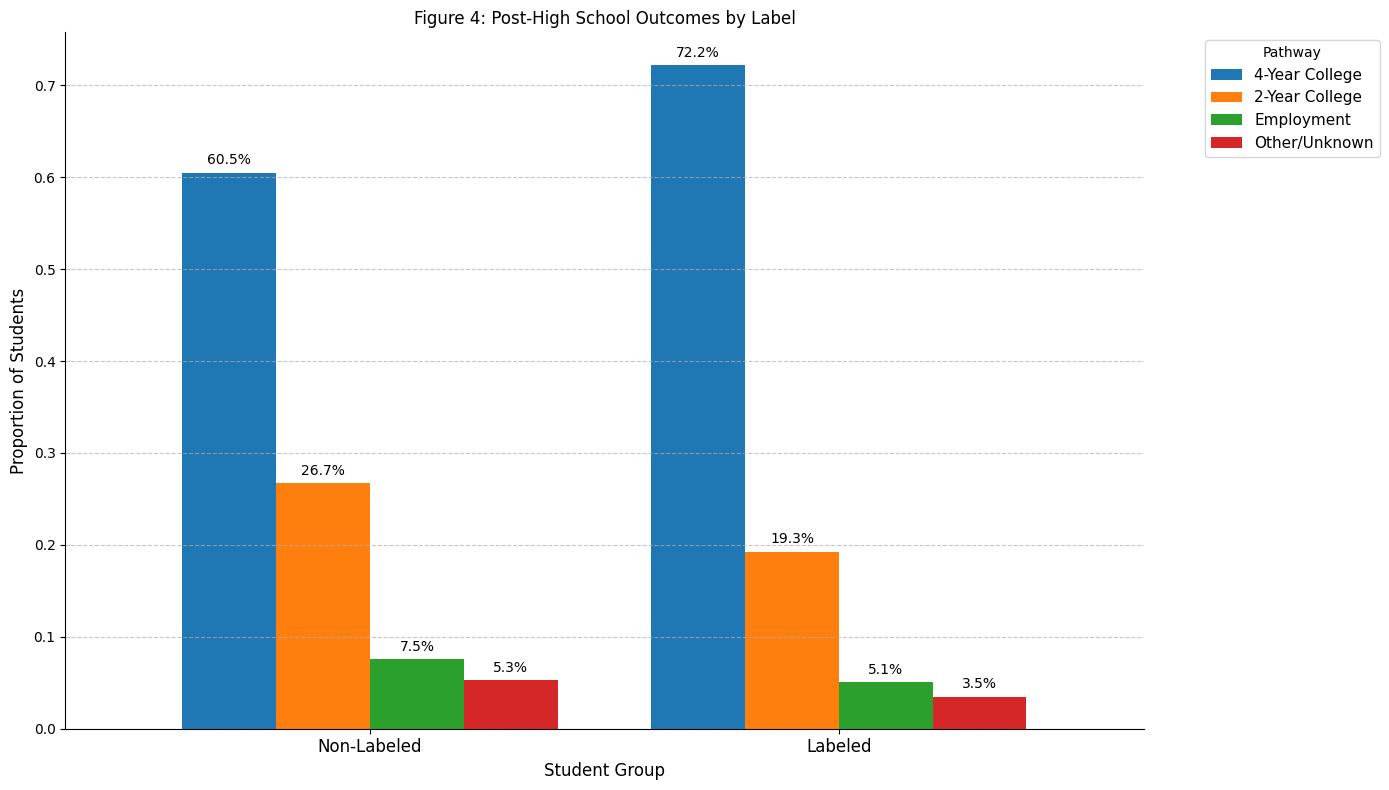

In [35]:

# --- `bound_for` Visualization ---
ax = pathway_props.plot(kind='bar', figsize=(14, 8), rot=0, width=0.8)
plt.ylabel('Proportion of Students', fontsize=12)
plt.xlabel('Student Group', fontsize=12)
plt.xticks(fontsize=12)
ax.set_xticklabels(['Non-Labeled','Labeled'])
plt.legend(title='Pathway', fontsize=11, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1%}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10)

ax.set_title("Figure 4: Post-High School Outcomes by Label")

plt.tight_layout()
plt.show()



--- Running Part 3: `bound_for` Switcher Analysis ---


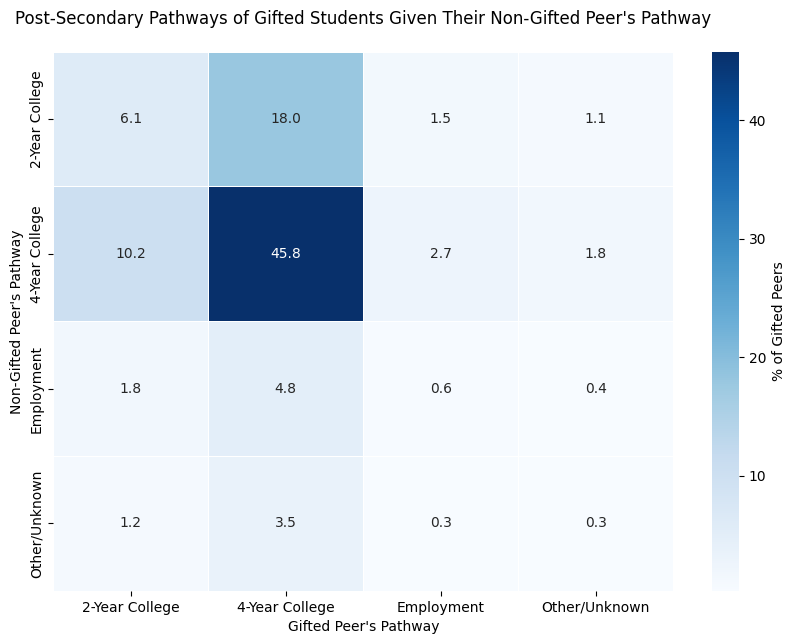


--- Running Part 4: Weighted GPA Subgroup Analysis ---


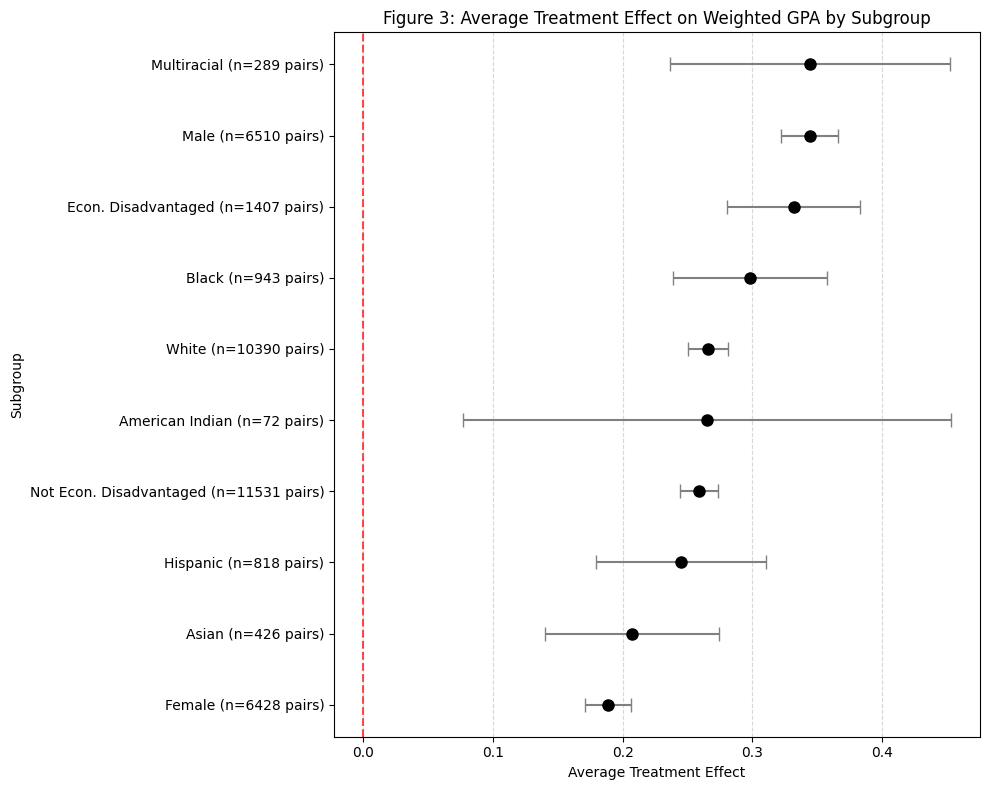

In [36]:
print("\n--- Running Part 3: `bound_for` Switcher Analysis ---")

pathway_clean = gpa_matches.dropna(subset=['pathway'])

# Create pairs of pathways
gifted_pathway = pathway_clean[pathway_clean['treatment'] == 1][['match_id', 'pathway']].set_index('match_id')
nongifted_pathway = pathway_clean[pathway_clean['treatment'] == 0][['match_id', 'pathway']].set_index('match_id')
pathway_pairs = nongifted_pathway.join(gifted_pathway, lsuffix='_nongifted', rsuffix='_gifted').dropna()

# Create the crosstab and normalize to get percentages
crosstab = pd.crosstab(pathway_pairs['pathway_nongifted'], pathway_pairs['pathway_gifted'])
crosstab_percent_global = crosstab / crosstab.values.sum() * 100

# Plotting the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(crosstab_percent_global, annot=True, fmt=".1f", cmap="Blues", linewidths=.5, cbar_kws={'label': '% of Gifted Peers'})
plt.title('Post-Secondary Pathways of Gifted Students Given Their Non-Gifted Peer\'s Pathway', pad=20)
plt.ylabel('Non-Gifted Peer\'s Pathway')
plt.xlabel('Gifted Peer\'s Pathway')
plt.show()


# --- PART 4: GPA Subgroup Analysis (Forest Plot) ---

print("\n--- Running Part 4: Weighted GPA Subgroup Analysis ---")
# Prepare data for this specific analysis
gpa_subgroup_data = gpa_matches.dropna(subset=['gpa_weighted'])

# Define subgroups (one at a time, no complements)
subgroup_map = {
    'sex_M': {1: 'Male', 0: 'Female'},
    'eds_Y': {1: 'Econ. Disadvantaged', 0: 'Not Econ. Disadvantaged'},
    'ethnic_W': {1: 'White'},
    'ethnic_B': {1: 'Black'},
    'ethnic_H': {1: 'Hispanic'},
    'ethnic_A': {1: 'Asian'},
    'ethnic_I': {1: 'American Indian'},
    'ethnic_M': {1: 'Multiracial'},
    'ethnic_P': {1: 'Pacific Islander'}
}

subgroup_results = []
for col, labels in subgroup_map.items():
    for val, label in labels.items():
        # Filter to pairs where the non-gifted student is in the subgroup
        sub_ids = gpa_subgroup_data[(gpa_subgroup_data['treatment'] == 0) & (gpa_subgroup_data[col] == val)]['match_id']
        sub_pairs = gpa_subgroup_data[gpa_subgroup_data['match_id'].isin(sub_ids)]
        
        # Get the number of unique pairs for the subgroup
        num_pairs_sub = sub_pairs['match_id'].nunique()
        if num_pairs_sub < 2: continue

        gifted_sub = sub_pairs[sub_pairs['treatment'] == 1].set_index('match_id')['gpa_weighted']
        nongifted_sub = sub_pairs[sub_pairs['treatment'] == 0].set_index('match_id')['gpa_weighted']
        diff_sub = gifted_sub - nongifted_sub.reindex(gifted_sub.index)
        
        ate = diff_sub.mean()
        ci = stats.t.interval(0.95, df=len(diff_sub)-1, loc=ate, scale=stats.sem(diff_sub))
        
        subgroup_results.append({'Subgroup': label, 'ATE': ate, 'CI_Lower': ci[0], 'CI_Upper': ci[1], 'N': num_pairs_sub})

# Create the Forest Plot
if subgroup_results:
    subgroup_df = pd.DataFrame(subgroup_results).sort_values('ATE')
    
    # Create a new column for labels that includes the sample size (n)
    subgroup_df['Subgroup_Label'] = subgroup_df.apply(lambda row: f"{row['Subgroup']} (n={row['N']} pairs)", axis=1)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    # Use the new 'Subgroup_Label' for the y-axis
    ax.errorbar(x=subgroup_df['ATE'], y=subgroup_df['Subgroup_Label'], 
                xerr=(subgroup_df['ATE'] - subgroup_df['CI_Lower'], subgroup_df['CI_Upper'] - subgroup_df['ATE']),
                fmt='o', capsize=5, color='black', ecolor='gray', markersize=8)
    
    ax.axvline(x=0, linestyle='--', color='red', alpha=0.7)
    ax.set_xlabel('Average Treatment Effect')
    ax.set_ylabel('Subgroup')
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_title("Figure 3: Average Treatment Effect on Weighted GPA by Subgroup")
    plt.tight_layout()
    plt.show()


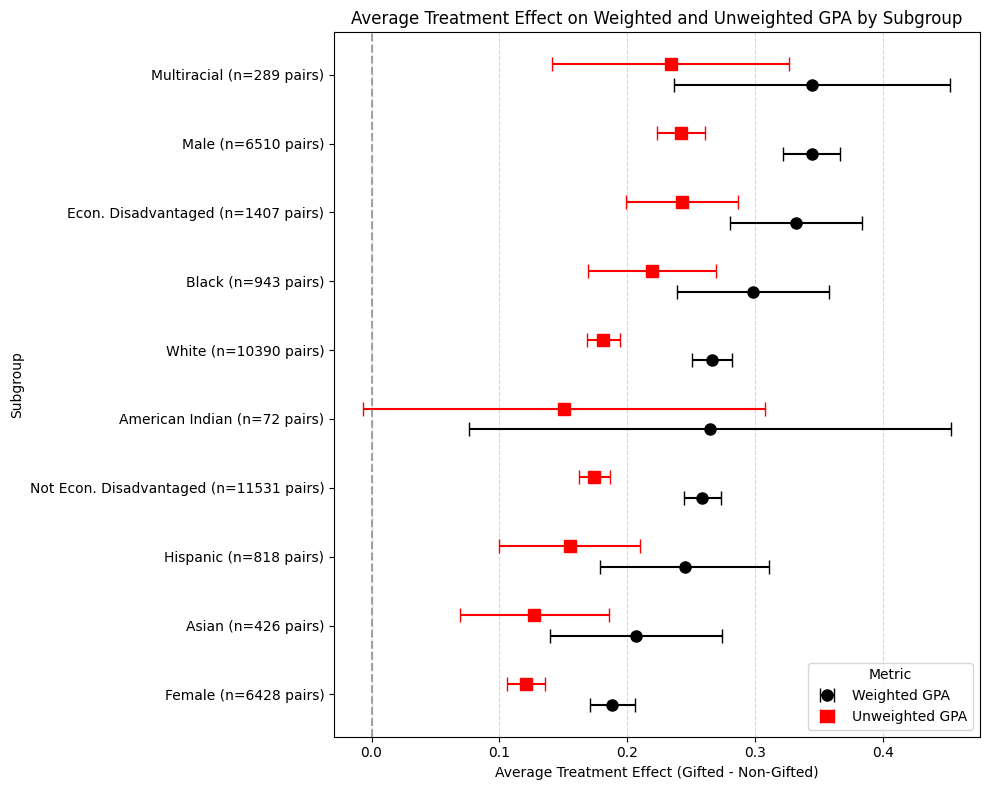

In [33]:


metrics = ['gpa_weighted', 'gpa_unweighted']

subgroup_map = {
    'sex_M': {1: 'Male', 0: 'Female'},
    'eds_Y': {1: 'Econ. Disadvantaged', 0: 'Not Econ. Disadvantaged'},
    'ethnic_W': {1: 'White'},
    'ethnic_B': {1: 'Black'},
    'ethnic_H': {1: 'Hispanic'},
    'ethnic_A': {1: 'Asian'},
    'ethnic_I': {1: 'American Indian'},
    'ethnic_M': {1: 'Multiracial'},
    'ethnic_P': {1: 'Pacific Islander'}
}

gpa_subgroup_data = gpa_matches.dropna(subset=['gpa_weighted', 'gpa_unweighted']) 

subgroup_results = []

for metric in metrics:
    for col, labels in subgroup_map.items():
        for val, label in labels.items():
            sub_ids = gpa_subgroup_data[(gpa_subgroup_data['treatment'] == 0) & (gpa_subgroup_data[col] == val)]['match_id']
            sub_pairs = gpa_subgroup_data[gpa_subgroup_data['match_id'].isin(sub_ids)]
            
            num_pairs_sub = sub_pairs['match_id'].nunique()
            if num_pairs_sub < 2: continue

            gifted_sub = sub_pairs[sub_pairs['treatment'] == 1].set_index('match_id')[metric]
            nongifted_sub = sub_pairs[sub_pairs['treatment'] == 0].set_index('match_id')[metric]
            
            diff_sub = gifted_sub - nongifted_sub.reindex(gifted_sub.index)
            
            ate = diff_sub.mean()
            
            if len(diff_sub) > 1 and stats.sem(diff_sub) > 0:
                ci = stats.t.interval(0.95, df=len(diff_sub)-1, loc=ate, scale=stats.sem(diff_sub))
            else:
                ci = (np.nan, np.nan)
            
            subgroup_results.append({
                'Metric': metric, 
                'Subgroup': label, 
                'ATE': ate, 
                'CI_Lower': ci[0], 
                'CI_Upper': ci[1], 
                'N': num_pairs_sub
            })

if subgroup_results:
    subgroup_df = pd.DataFrame(subgroup_results).dropna(subset=['ATE', 'CI_Lower', 'CI_Upper'])
    
    weighted_gpa_order = subgroup_df[subgroup_df['Metric'] == 'gpa_weighted'].sort_values('ATE')['Subgroup'].unique().tolist()
    
    subgroup_df['Subgroup'] = pd.Categorical(subgroup_df['Subgroup'], categories=weighted_gpa_order, ordered=True)
    subgroup_df = subgroup_df.sort_values(['Subgroup', 'Metric'])
    
    n_map = subgroup_df.drop_duplicates(subset=['Subgroup'])[['Subgroup', 'N']].set_index('Subgroup')['N'].to_dict()
    subgroup_df['Subgroup_Label'] = subgroup_df['Subgroup'].apply(lambda x: f"{x} (n={n_map.get(x, 'N/A')} pairs)")

    fig, ax = plt.subplots(figsize=(10, 8))
    
    metrics_to_plot = ['gpa_weighted', 'gpa_unweighted']
    metric_styles = {
        'gpa_weighted': {'color': 'black', 'marker': 'o', 'label': 'Weighted GPA'},
        'gpa_unweighted': {'color': 'red', 'marker': 's', 'label': 'Unweighted GPA'}
    }
    
    y_labels = subgroup_df['Subgroup_Label'].unique().tolist()
    y_pos = np.arange(len(y_labels))
    label_to_pos = {label: pos for pos, label in enumerate(y_labels)}

    for i, metric in enumerate(metrics_to_plot):
        metric_df = subgroup_df[subgroup_df['Metric'] == metric].copy()
        style = metric_styles[metric]
        
        offset = (-0.15 if i == 0 else 0.15) 
        y_locs = [label_to_pos[label] + offset for label in metric_df['Subgroup_Label']]
        
        xerr = (metric_df['ATE'] - metric_df['CI_Lower'], metric_df['CI_Upper'] - metric_df['ATE'])
        
        ax.errorbar(x=metric_df['ATE'], 
                    y=y_locs, 
                    xerr=xerr,
                    fmt=style['marker'],         
                    capsize=5, 
                    color=style['color'], 
                    ecolor=style['color'], 
                    markersize=8,
                    label=style['label'])

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels)

    ax.axvline(x=0, linestyle='--', color='gray', alpha=0.7)
    
    ax.set_xlabel('Average Treatment Effect (Gifted - Non-Gifted)')
    ax.set_ylabel('Subgroup')
    ax.set_title("Average Treatment Effect on Weighted and Unweighted GPA by Subgroup")
    
    ax.legend(title='Metric', loc='lower right')
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


--- Likelihood of Taking College Entrance Exams ---

Analysis for Took Act:
took_act   False  True 
treatment              
0           4227   8711
1           4681   8257
Chi-Square Test: p-value = 3.084e-09

Analysis for Took Sat:
took_sat   False  True 
treatment              
0           6433   6505
1           5376   7562
Chi-Square Test: p-value = 1.149e-39

Analyzing 'ACT' scores with 6010 complete pairs.

Analyzing 'SAT' scores with 4175 complete pairs.

--- Exam Score Analysis Results (ATE) ---
  Exam  ATE (Mean Diff)        p_value   CI Lower   CI Upper     N
0  ACT         2.456905  2.893132e-300   2.334215   2.579595  6010
1  SAT        77.817964  4.618681e-218  73.263018  82.372910  4175


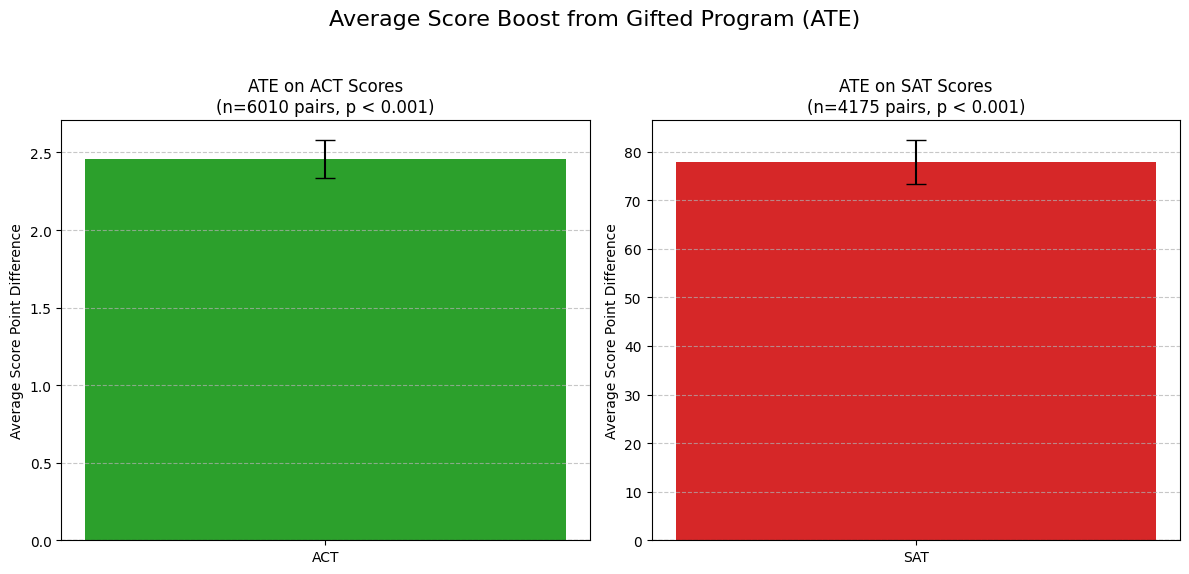

In [37]:

# Merge with the main dataframe
exam_matches = gpa_matches.merge(act[['mastid', 'ACCO','ACEN','ACMA','ACRD','ACSC']], on='mastid', how='left')
exam_matches = exam_matches.merge(sat[['mastid', 'SAT_Total_Score_HC']], on='mastid', how='left')

# --- 5a. Likelihood of Taking an Exam ---
exam_matches['took_act'] = ~exam_matches['ACCO'].isna()
exam_matches['took_sat'] = ~exam_matches['SAT_Total_Score_HC'].isna()

print("\n--- Likelihood of Taking College Entrance Exams ---")
for exam in ['took_act', 'took_sat']:
    contingency_table = pd.crosstab(exam_matches['treatment'], exam_matches[exam])
    if contingency_table.shape != (2, 2):
        print(f"\nSkipping {exam.replace('_', ' ').title()} due to lack of variation.")
        continue
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"\nAnalysis for {exam.replace('_', ' ').title()}:")
    print(contingency_table)
    print(f"Chi-Square Test: p-value = {p:.3e}")

# --- 5b. ATE on Exam Scores (for test-takers) ---
exam_results = []
for exam, score_col in [('ACT', 'ACCO'), ('SAT', 'SAT_Total_Score_HC')]:
    # Isolate relevant columns and drop any student who didn't take the exam
    exam_subset = exam_matches[['match_id', 'treatment', score_col]].dropna()
    
    # Pivot to align scores by match_id
    pivoted = exam_subset.pivot_table(index='match_id', columns='treatment', values=score_col)
    # Drop pairs where one member didn't take the exam but the other did
    pivoted.dropna(inplace=True)

    num_pairs = len(pivoted)
    print(f"\nAnalyzing '{exam}' scores with {num_pairs} complete pairs.")
    if num_pairs < 2: continue # Need at least 2 pairs for a t-test
    
    # Calculate the difference for each pair
    diff = pivoted[1] - pivoted[0]
    
    # Perform a one-sample t-test on the differences (equivalent to a paired t-test)
    # H0: The mean of the differences is 0.
    t_stat, p_value = stats.ttest_1samp(diff, 0)
    
    exam_results.append({
        'Exam': exam,
        'ATE (Mean Diff)': diff.mean(),
        'p_value': p_value,
        'CI Lower': stats.t.interval(0.95, df=len(diff)-1, loc=diff.mean(), scale=stats.sem(diff))[0],
        'CI Upper': stats.t.interval(0.95, df=len(diff)-1, loc=diff.mean(), scale=stats.sem(diff))[1],
        'N': num_pairs
    })

if exam_results:
    exam_results_df = pd.DataFrame(exam_results)
    print("\n--- Exam Score Analysis Results (ATE) ---")
    print(exam_results_df)

    # --- Visualization with Separate Axes ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    fig.suptitle('Average Score Boost from Gifted Program (ATE)', fontsize=16)
    
    colors = {'ACT': '#2ca02c', 'SAT': '#d62728'}

    for i, row in exam_results_df.iterrows():
        ax = axes[i]
        exam_name = row['Exam']
        ate = row['ATE (Mean Diff)']
        p_val = row['p_value']
        ci_lower = row['CI Lower']
        ci_upper = row['CI Upper']
        error = ate - ci_lower # Symmetric error for CI
        sample_size = row['N']
        
        # Format p-value for display
        p_text = f"p < 0.001" if p_val < 0.001 else f"p = {p_val:.3f}"

        ax.bar(exam_name, ate, yerr=error, capsize=7, color=colors.get(exam_name, 'gray'), width=0.5)
        ax.set_title(f"ATE on {exam_name} Scores\n(n={sample_size} pairs, {p_text})")
        ax.set_ylabel('Average Score Point Difference')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [36]:
exam_matches = pairs.merge(act[['mastid', 'ACCO']], on='mastid', how='left')
exam_matches = exam_matches.merge(sat[['mastid', 'SAT_Total_Score_HC']], on='mastid', how='left')

# Create boolean columns for whether a student took an exam
exam_matches['took_act'] = ~exam_matches['ACCO'].isna()
exam_matches['took_sat'] = ~exam_matches['SAT_Total_Score_HC'].isna()

print("\n--- Likelihood of Taking College Entrance Exams ---")
for exam in ['took_act', 'took_sat']:
    # Create a contingency table (crosstab) of treatment status vs. exam taking
    contingency_table = pd.crosstab(exam_matches['treatment'], exam_matches[exam])
    
    # Perform the Chi-Squared Test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    # Print the results
    print(f"\nAnalysis for {exam.replace('_', ' ').title()}:")
    print("Observed Frequencies (treatment vs took_exam):")
    print(contingency_table)
    print(f"Chi-Square Test: χ²({dof}) = {chi2:.2f}, p-value = {p:.4f}")

    if p < 0.05:
        print("Result: There is a statistically significant association between treatment status and the likelihood of taking this exam.")
    else:
        print("Result: There is no statistically significant association.")




--- Likelihood of Taking College Entrance Exams ---

Analysis for Took Act:
Observed Frequencies (treatment vs took_exam):
took_act   False  True 
treatment              
0          11391  12188
1          10419  13160
Chi-Square Test: χ²(1) = 80.43, p-value = 0.0000
Result: There is a statistically significant association between treatment status and the likelihood of taking this exam.

Analysis for Took Sat:
Observed Frequencies (treatment vs took_exam):
took_sat   False  True 
treatment              
0          15574   8005
1          12660  10919
Chi-Square Test: χ²(1) = 748.95, p-value = 0.0000
Result: There is a statistically significant association between treatment status and the likelihood of taking this exam.


In [29]:
#end of gemini

In [30]:

act_scores = pd.read_csv("data/interim/act.csv")
acts = pairs.merge(act_scores, on='mastid',how='left')
acts.dropna(inplace=True)
duplicate_counts = acts['match_id'].value_counts()
duplicates_only = duplicate_counts[duplicate_counts > 1]

acts = acts[acts['match_id'].isin(duplicates_only.index)]


# Step 1: Filter to test_id == 'ACCO'

# Step 2: Keep only match_ids that appear exactly twice (valid pairs)
valid_pairs = acts['match_id'].value_counts()
valid_pairs = valid_pairs[valid_pairs == 2].index
acts = acts[acts['match_id'].isin(valid_pairs)]

# Step 3: Sort so gifted comes first
act_pairs = acts.sort_values('gifted_grade', ascending=False)



\n--- Processing: ACCO ---


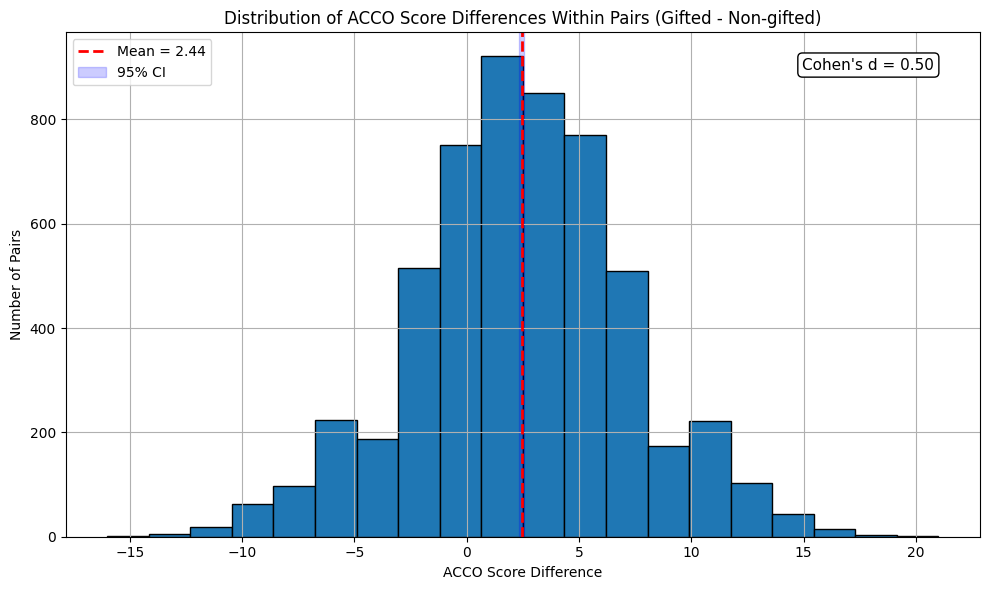

\n--- Processing: ACMA ---


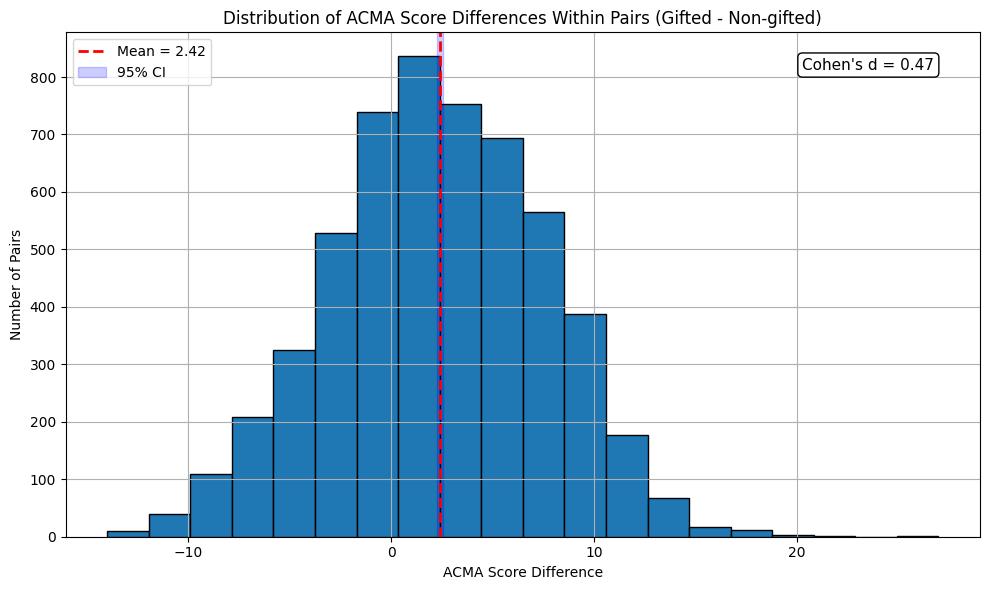

\n--- Processing: ACRD ---


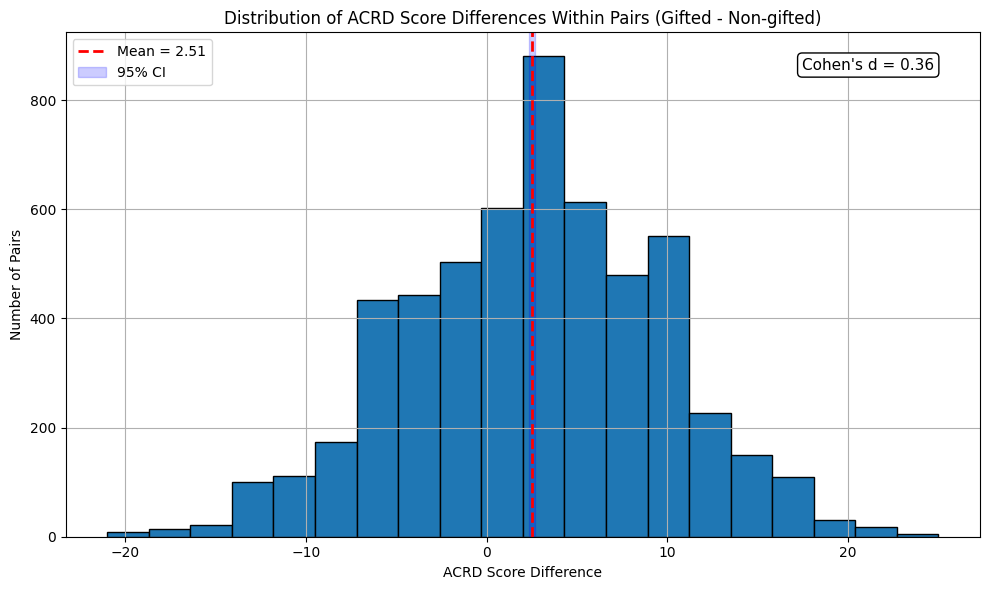

\n--- Processing: ACEN ---


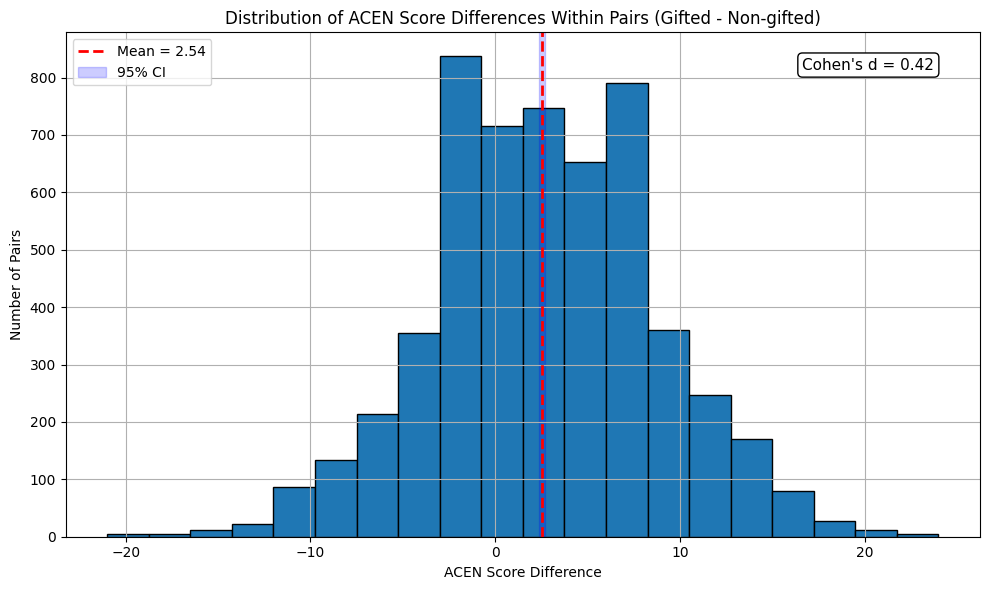

\n--- Processing: ACSC ---


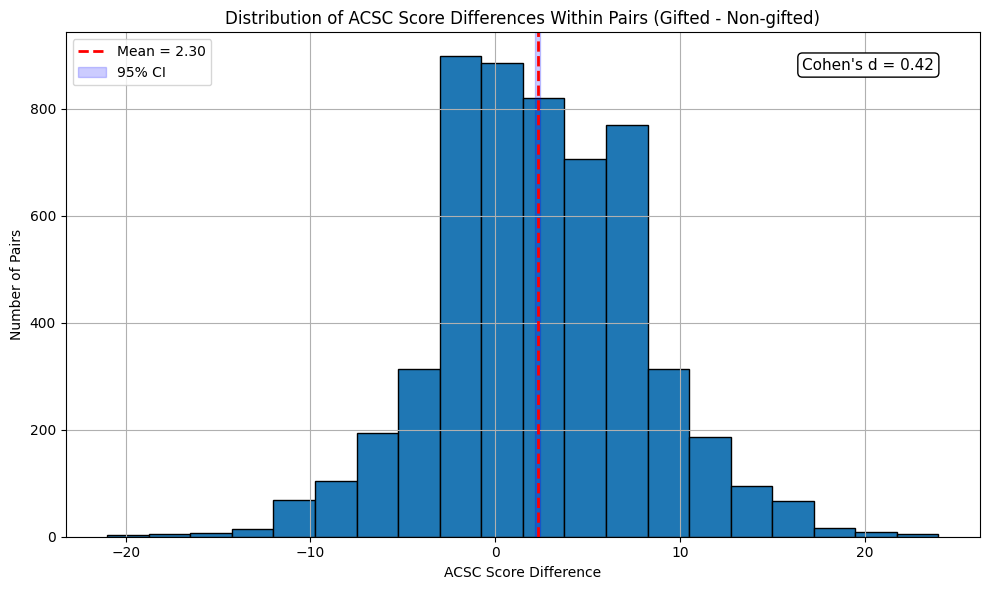

In [31]:
act_subject_cols = ['ACCO','ACMA', 'ACRD', 'ACEN', 'ACSC']
sat_subject_cols = ['SAT_EBRW_Score_HC','SAT_Total_Score_HC','SAT_Math_Score_HC']
# --- 2. Loop Through Each Subject ---
for subject in act_subject_cols:
    print(f"\\n--- Processing: {subject} ---")

    # --- 3. Prepare Data for the Subject ---
    subject_df = act_pairs[['match_id', 'treatment', subject]].dropna()
    
    pivoted_scores = subject_df.pivot(index='match_id', columns='treatment', values=subject)
    
    if 0 not in pivoted_scores.columns or 1 not in pivoted_scores.columns:
        print(f"Skipping {subject}: Not enough data for a paired comparison.")
        continue
        
    pivoted_scores.columns = ['non_gifted', 'gifted']
    act_diff = (pivoted_scores['gifted'] - pivoted_scores['non_gifted']).dropna()
    
    if len(act_diff) < 2:
        print(f"Skipping {subject}: Not enough complete pairs to calculate stats.")
        continue

    # --- 4. Compute Stats ---
    mean_diff = act_diff.mean()
    se_diff = stats.sem(act_diff)
    ci_lower, ci_upper = stats.t.interval(0.95, df=len(act_diff) - 1, loc=mean_diff, scale=se_diff)
    
    std_dev = act_diff.std(ddof=1)
    cohen_d = mean_diff / std_dev if std_dev > 0 else 0

    # --- 5. Plot ---
    plt.figure(figsize=(10, 6))
    plt.hist(act_diff, bins=20, edgecolor='black')
    plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_diff:.2f}')
    plt.axvspan(ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')

    plt.text(0.95, 0.95, f"Cohen's d = {cohen_d:.2f}", transform=plt.gca().transAxes,
             ha='right', va='top', fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.title(f'Distribution of {subject} Score Differences Within Pairs (Gifted - Non-gifted)')
    plt.xlabel(f'{subject} Score Difference')
    plt.ylabel('Number of Pairs')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
for subject in sat_subject_cols:
    print(f"\\n--- Processing: {subject} ---")

    # --- 3. Prepare Data for the Subject ---
    subject_df = act_pairs[['match_id', 'treatment', subject]].dropna()
    
    pivoted_scores = subject_df.pivot(index='match_id', columns='treatment', values=subject)
    
    if 0 not in pivoted_scores.columns or 1 not in pivoted_scores.columns:
        print(f"Skipping {subject}: Not enough data for a paired comparison.")
        continue
        
    pivoted_scores.columns = ['non_gifted', 'gifted']
    act_diff = (pivoted_scores['gifted'] - pivoted_scores['non_gifted']).dropna()
    
    if len(act_diff) < 2:
        print(f"Skipping {subject}: Not enough complete pairs to calculate stats.")
        continue

    # --- 4. Compute Stats ---
    mean_diff = act_diff.mean()
    se_diff = stats.sem(act_diff)
    ci_lower, ci_upper = stats.t.interval(0.95, df=len(act_diff) - 1, loc=mean_diff, scale=se_diff)
    
    std_dev = act_diff.std(ddof=1)
    cohen_d = mean_diff / std_dev if std_dev > 0 else 0

    # --- 5. Plot ---
    plt.figure(figsize=(10, 6))
    plt.hist(act_diff, bins=20, edgecolor='black')
    plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_diff:.2f}')
    plt.axvspan(ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')

    plt.text(0.95, 0.95, f"Cohen's d = {cohen_d:.2f}", transform=plt.gca().transAxes,
             ha='right', va='top', fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.title(f'Distribution of {subject} Score Differences Within Pairs (Gifted - Non-gifted)')
    plt.xlabel(f'{subject} Score Difference')
    plt.ylabel('Number of Pairs')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

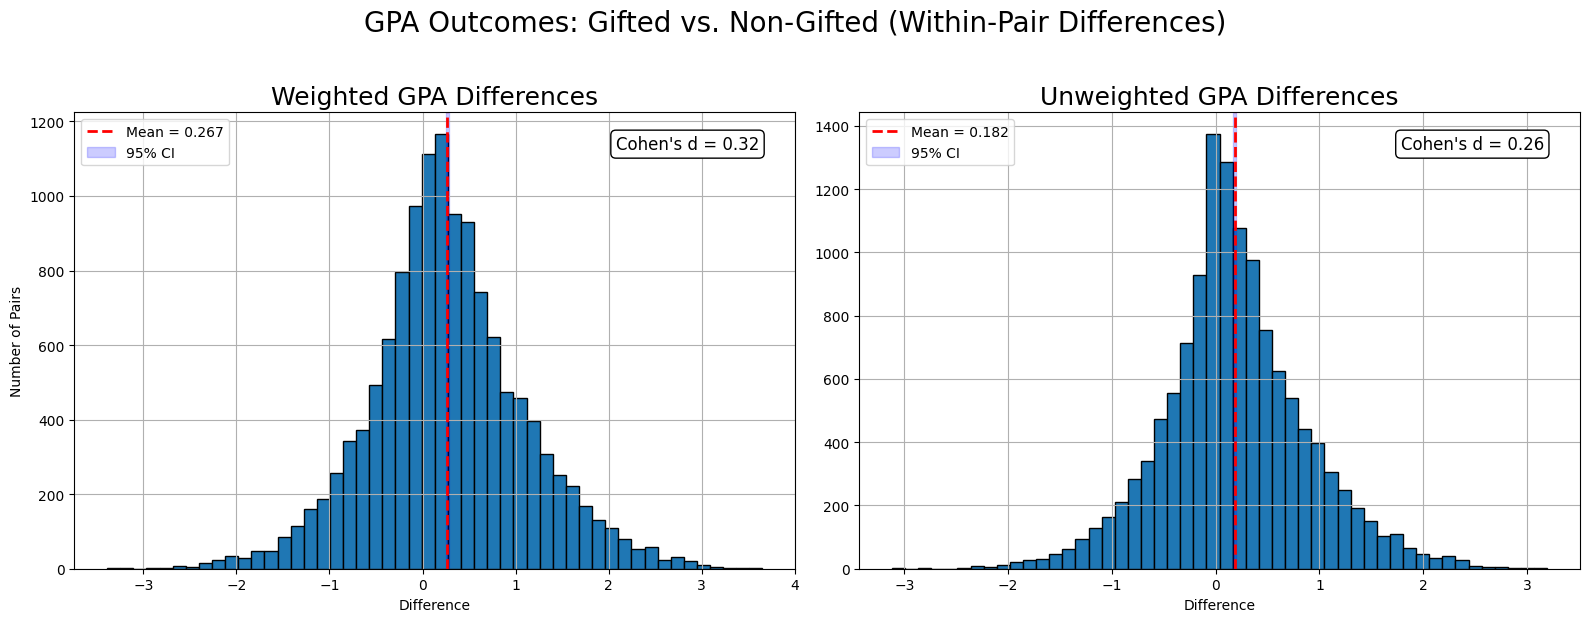

In [32]:
import matplotlib.pyplot as plt

# --- 1. Create a 1x2 Subplot Grid ---
# This creates a 1D axes array with two plot areas.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# --- 2. Create the GPA Plots ---

# === Weighted GPA Plot (Left) ===
# Access the first plot area using axes[0]
gpa_weight_ax = axes[0]

# (Your existing code to calculate weighted_diff, mean_weighted, etc. goes here)
gpa_weight_ax.hist(weighted_diff, bins=50, edgecolor='black')
gpa_weight_ax.axvline(mean_weighted, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_weighted:.3f}')
gpa_weight_ax.axvspan(ci_weighted[0], ci_weighted[1], color='blue', alpha=0.2, label='95% CI')
gpa_weight_ax.set_title('Weighted GPA Differences', fontsize=18)
gpa_weight_ax.set_xlabel('Difference')
gpa_weight_ax.set_ylabel('Number of Pairs')
gpa_weight_ax.grid(True)
gpa_weight_ax.legend()
gpa_weight_ax.text(0.95, 0.95, f"Cohen's d = {cohen_d_weighted:.2f}", transform=gpa_weight_ax.transAxes,
                   ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# === Unweighted GPA Plot (Right) ===
# Access the second plot area using axes[1]
gpa_unweight_ax = axes[1]

# (Your existing code to calculate unweighted_diff, mean_unweighted, etc. goes here)
gpa_unweight_ax.hist(unweighted_diff, bins=50, edgecolor='black')
gpa_unweight_ax.axvline(mean_unweighted, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mean_unweighted:.3f}')
gpa_unweight_ax.axvspan(ci_unweighted[0], ci_unweighted[1], color='blue', alpha=0.2, label='95% CI')
gpa_unweight_ax.set_title('Unweighted GPA Differences', fontsize=18)
gpa_unweight_ax.set_xlabel('Difference')
gpa_unweight_ax.grid(True)
gpa_unweight_ax.legend()
gpa_unweight_ax.text(0.95, 0.95, f"Cohen's d = {cohen_d_unweighted:.2f}", transform=gpa_unweight_ax.transAxes,
                     ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# --- 3. Final Touches ---
fig.suptitle("GPA Outcomes: Gifted vs. Non-Gifted (Within-Pair Differences)", fontsize=20, y=1.03)
plt.tight_layout()
plt.show()